# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 30.11.2020 01:00

Мягкий дедлайн: 01:00MSK 14.12.2020

Жесткий дедлайн: 01:00MSK 21.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import sklearn.metrics as metrics
import time

In [25]:
from sklearn.datasets import load_boston

In [26]:
boston = load_boston()

In [27]:
X = boston["data"]
y = boston["target"]

In [28]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.018134470056786

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [29]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ind = np.arange(0, X.shape[0])
    preds = np.zeros((X.shape[0], num_runs))
    counts = np.zeros(X.shape[0]).astype(int)
    for i in range(num_runs):
        indices = np.random.randint(0, X.shape[0], X.shape[0])
        a = regressor()
        a.fit(X[indices], y[indices])
        test_ind = np.setxor1d(indices, ind)
        preds[test_ind, i] = a.predict(X[test_ind])
        counts[test_ind] += 1
    mean = np.sum(preds, axis=1)
    mean[counts != 0] = mean[counts != 0] / counts[counts != 0]
    bias = np.mean(np.where(mean != 0, (mean - y) ** 2, mean)[counts != 0])
    variance = np.where(preds != 0, preds - mean[:, np.newaxis], preds) ** 2
    variance = np.sum(variance, axis=1)
    variance = variance[counts != 0] / counts[counts != 0]
    variance = np.mean(variance)
    error = np.where(preds != 0, preds - y[:, np.newaxis], preds) ** 2
    error = np.sum(error) / np.sum(counts)
    return bias, variance, error

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [67]:
bias, variance, error = compute_biase_variance(LinearRegression, X, y, num_runs=100)
print("bias =", bias)
print("variance =", variance)
print("error =", error)
print("abs =", np.abs(error - (bias + variance)))

bias = 23.820814887423033
variance = 0.8950403447955912
error = 24.695319563437437
abs = 0.020535668781189287


In [68]:
bias, variance, error = compute_biase_variance(DecisionTreeRegressor, X, y, num_runs=100)
print("bias =", bias)
print("variance =", variance)
print("error =", error)
print("abs =", np.abs(error - (bias + variance)))

bias = 10.827500295984695
variance = 12.575682760982424
error = 23.533640144763137
abs = 0.1304570877960174


In [69]:
bias, variance, error = compute_biase_variance(RandomForestRegressor, X, y, num_runs=100)
print("bias =", bias)
print("variance =", variance)
print("error =", error)
print("abs =", np.abs(error - (bias + variance)))

bias = 10.68987645824009
variance = 2.352436589206859
error = 13.056282997700043
abs = 0.01396995025309522


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ Можно заметить, что сумма смещения и разброса примерно равна ошибке, что согласуется с теоретическими рассчетами. Проанализируем модели по-отдельности. Для линейной регрессии смещение большое, а разброс маленький. На семинаре было показано, что это характерно для простых алгоритмов, т.к. смещение предсказывает то, насколько хорошо алгоритм способен приблизить оптимальный. Для решающего дерева, наоборот, смешение низкое, а разброс высокий, т.к. этот алгоритм чувствительнее к обучающей выборке. Лучший результат получился для случайного леса, т.к. бэггинг позволяет объединить несмещенные, но чувствительные к обучающей выборке алгоритмы в несмещенную композицию с низкой дисперсией, а случайный лес как раз является примером такого алгоритма. Поэтому у него получилось относительно низкие смещение и разброс.

Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В теории, если базовые алгоритмы некоррелированы, то дисперсия композиции в N
раз меньше дисперсии отдельных алгоритмов, где N - длина композиции. В наших экспериментах это не выполняется, потому что модели коррелированы.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [235]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=ax):
    """
    plot graphics described above
    """
    np.random.seed(14)
    ind = np.arange(X.shape[0])
    np.random.shuffle(ind)
    test_ind = ind[:num_test_objects]
    train_ind = np.setxor1d(test_ind, np.arange(X.shape[0]))
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    predictions = np.zeros((num_test_objects, num_runs))
    for i in range(num_runs):
        indices = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        a = regressor()
        a.fit(X_train[indices], y_train[indices])
        predictions[:, i] = a.predict(X_test)
    objects = np.arange(num_test_objects)
    ax.scatter(objects, y_test, c='black', s=60, zorder=num_test_objects+1)
    for obj in objects:
        ax.scatter(np.ones(num_runs)*obj, predictions[obj])
    ax.set_title(title)
    ax.set_xlabel("Object number")
    ax.set_ylabel("Prediction values")
    ax.set_xticks(objects)
    ax.grid(linewidth=0.7)

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

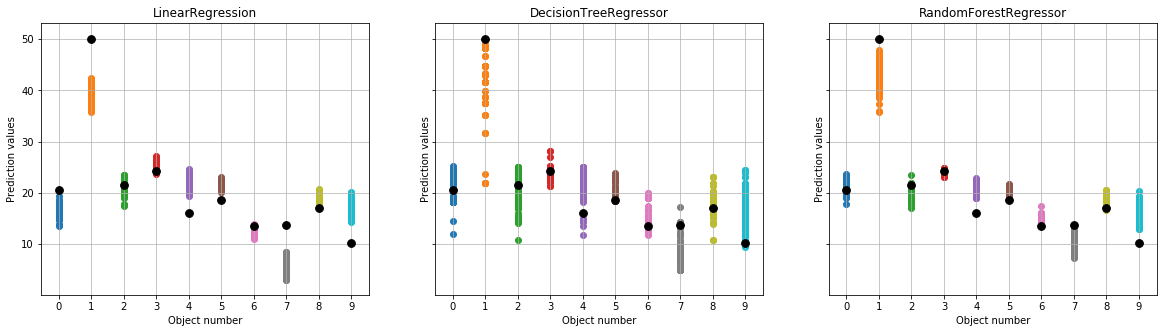

In [236]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
plot_predictions(LinearRegression, X, y, num_runs=100, num_test_objects=10, title="LinearRegression", ax=ax1)
plot_predictions(DecisionTreeRegressor, X, y, num_runs=100, num_test_objects=10, title="DecisionTreeRegressor", ax=ax2)
plot_predictions(RandomForestRegressor, X, y, num_runs=100, num_test_objects=10, title="RandomForestRegressor", ax=ax3)

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:** Можно заметить, что построенный график подтверждает проведенные ранее рассчеты: наибольшее смещение получается в случае Линейной регрессии. Часто реальные значения оказываются за пределами предсказанных. При этом ее разброс маленький относительно других алгоритмов: регрессия нечувствительна к обучающей выборке, но плохо приближает оптимальный алгоритм, поэтому предсказанные значения представляют из себя сплошные столбики. 
В случае решающего дерева разброс самый большой среди всех алгоритмов: предсказанные значения подстроились под обучающую выборку, поэтому они значительно различаются друг от друга. Однако смещение маленькое: реальные значения всегда находятся внутри столбиков-предсказаний.
В Случайном лесе разброс почти такой же маленький, как в случае Линейной регрессии. Смещение чуть больше, чем для Решающего дерева, но довольно небольшое. График подтверждает то, что Решающий лес является одним из лучших алгоритмов для применения бэггинга.

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869) (вам нужны только данные, посылать туда ничего не надо).
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы:
    * Воспользуйтесь описанием соревнования
    * При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

Нашла на гитхабе замечательный модуль для отбора признаков. Прикрепляю его в виде .py.
https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py
Также прикладываю статью, в которой показан процесс работы с этим модулем: https://proglib.io/p/feature-selector/

In [2]:
import feature_selector as f_s

In [3]:
data = pd.read_csv('application_train.csv')
Y = data.TARGET.values
data = data.drop('TARGET', axis=1)

In [10]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
fs = f_s.FeatureSelector(data=data, labels=Y)

Сначала рассмотрим признаки, в которых слишком много пропущенных значений. Выставим границу в 0.69 и посмотрим, сколько таких признаков присутствует в нашем датасете.

In [5]:
fs.identify_missing(missing_threshold = 0.69)

6 features with greater than 0.69 missing values.



In [6]:
fs.missing_stats.head(6)

,missing_fraction
COMMONAREA_AVG,0.698593
COMMONAREA_MODE,0.698593
COMMONAREA_MEDI,0.698593
NONLIVINGAPARTMENTS_AVG,0.694087
NONLIVINGAPARTMENTS_MODE,0.694087
NONLIVINGAPARTMENTS_MEDI,0.694087


Далее проверим наличие коррелированных признаков. Они приводят к ухудшению предсказания. Метод выбирает из попарно скоррелированных признаков один для удаления. Также рассмотрим тепловую карту признаков.

In [7]:
fs.identify_collinear(correlation_threshold = 0.99)

14 features with a correlation magnitude greater than 0.99.



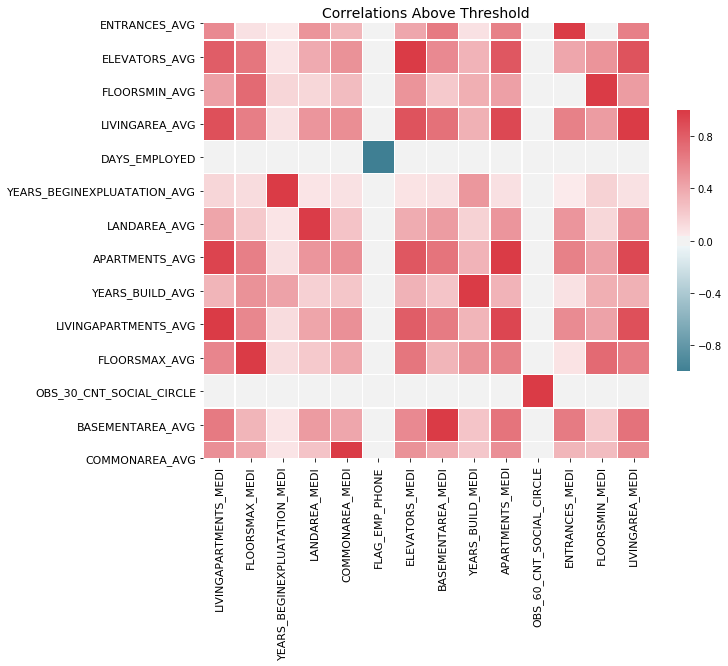

In [8]:
fs.plot_collinear()

Можно заметить некоторую закономерность: опять признаки, описывающие здание, в котором проживает клиент, оказались неинформативными.

Далее установим важность признаков с помощью алгоритма градиентного бустинга из библиотеки LightGBM и удалим признаки, которые имеют нулевую важность.

In [9]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'pr', 
                            n_iterations = 10, 
                             early_stopping = True)

zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.246668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.248358
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.250487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.247048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.250238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.248903
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's binary_logloss: 0.245974


Интересно посмотреть, какие признаки оказались самыми важными для предсказания.

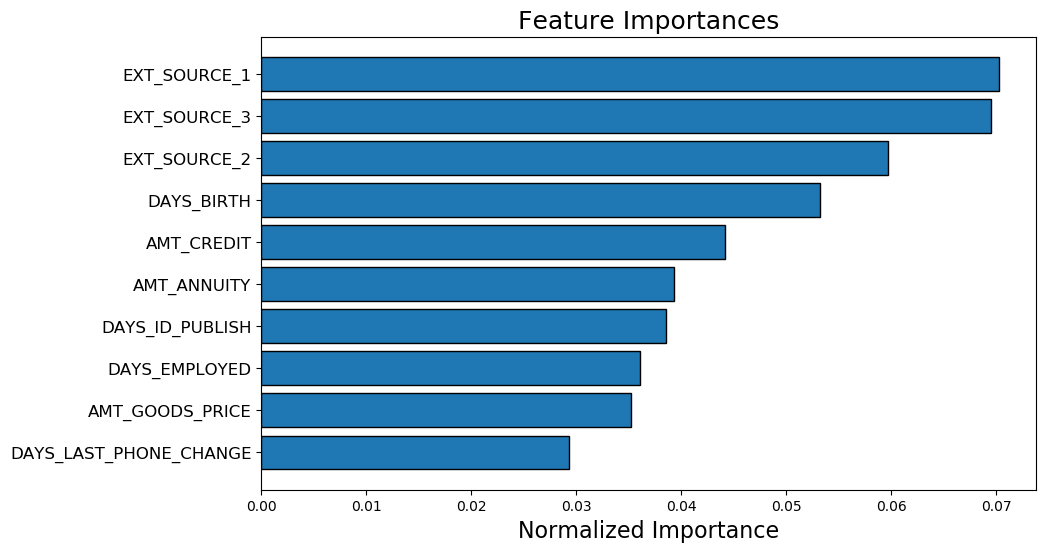

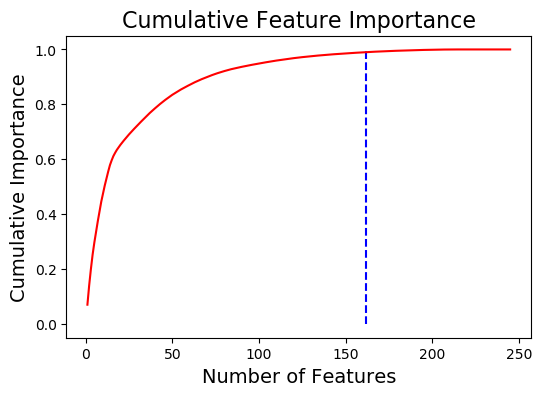

162 features required for 0.99 of cumulative importance


In [10]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 10)

In [11]:
removed_data = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'collinear', 'zero_importance'] methods have been run

Removed 169 features including one-hot features.


In [12]:
removed_data.shape

(215257, 92)

In [13]:
data.shape

(215257, 121)

Нам удалось удалить 29 признаков! Теперь заполним пропущенные значения в зависимости от типа данных.

In [14]:
numeric_features = []
categorical = []
str_f = []

for column in removed_data.columns:
    if removed_data[column].dtype == 'int64':
        removed_data[column].fillna(0, inplace=True)
        numeric_features.append(column)
    elif removed_data[column].dtype == 'float64':
        numeric_features.append(column)
        removed_data[column].fillna(removed_data[column].mean(), inplace=True)
    elif removed_data[column].dtype == 'object':
        categorical.append(column)
        if type(removed_data[column][0]) == str:
            str_f.append(column)
        removed_data[column].fillna('', inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(removed_data, Y, test_size=0.3, random_state=0, stratify=Y)

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Получилась ли заметная разница в качестве? Как вы думаете, почему?**

**Замечание:**
* В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [329]:
%%time

model = LGBMClassifier()
model.fit(X_train[numeric_features], y_train)

Wall time: 3.23 s


LGBMClassifier()

In [330]:
%%time

cat = CatBoostClassifier()
cat.fit(X_train[numeric_features], y_train)

Learning rate set to 0.086068
0:	learn: 0.6060705	total: 67ms	remaining: 1m 6s
1:	learn: 0.5377729	total: 133ms	remaining: 1m 6s
2:	learn: 0.4821831	total: 219ms	remaining: 1m 12s
3:	learn: 0.4391396	total: 323ms	remaining: 1m 20s
4:	learn: 0.4032135	total: 407ms	remaining: 1m 20s
5:	learn: 0.3782077	total: 460ms	remaining: 1m 16s
6:	learn: 0.3557754	total: 536ms	remaining: 1m 16s
7:	learn: 0.3380496	total: 610ms	remaining: 1m 15s
8:	learn: 0.3241447	total: 696ms	remaining: 1m 16s
9:	learn: 0.3124284	total: 781ms	remaining: 1m 17s
10:	learn: 0.3018884	total: 858ms	remaining: 1m 17s
11:	learn: 0.2937104	total: 942ms	remaining: 1m 17s
12:	learn: 0.2869542	total: 1.05s	remaining: 1m 19s
13:	learn: 0.2819781	total: 1.14s	remaining: 1m 20s
14:	learn: 0.2780728	total: 1.22s	remaining: 1m 20s
15:	learn: 0.2741524	total: 1.3s	remaining: 1m 19s
16:	learn: 0.2710923	total: 1.37s	remaining: 1m 19s
17:	learn: 0.2686437	total: 1.44s	remaining: 1m 18s
18:	learn: 0.2663888	total: 1.5s	remaining: 1m 1

161:	learn: 0.2429039	total: 12.1s	remaining: 1m 2s
162:	learn: 0.2428529	total: 12.2s	remaining: 1m 2s
163:	learn: 0.2427677	total: 12.3s	remaining: 1m 2s
164:	learn: 0.2427026	total: 12.4s	remaining: 1m 2s
165:	learn: 0.2426534	total: 12.5s	remaining: 1m 2s
166:	learn: 0.2425919	total: 12.6s	remaining: 1m 2s
167:	learn: 0.2425460	total: 12.6s	remaining: 1m 2s
168:	learn: 0.2425031	total: 12.7s	remaining: 1m 2s
169:	learn: 0.2424373	total: 12.7s	remaining: 1m 2s
170:	learn: 0.2423664	total: 12.8s	remaining: 1m 2s
171:	learn: 0.2422931	total: 12.9s	remaining: 1m 1s
172:	learn: 0.2422329	total: 12.9s	remaining: 1m 1s
173:	learn: 0.2422007	total: 13s	remaining: 1m 1s
174:	learn: 0.2421354	total: 13s	remaining: 1m 1s
175:	learn: 0.2420734	total: 13.1s	remaining: 1m 1s
176:	learn: 0.2420215	total: 13.2s	remaining: 1m 1s
177:	learn: 0.2419748	total: 13.2s	remaining: 1m 1s
178:	learn: 0.2419241	total: 13.3s	remaining: 1m 1s
179:	learn: 0.2418445	total: 13.4s	remaining: 1m 1s
180:	learn: 0.24

321:	learn: 0.2350818	total: 23s	remaining: 48.4s
322:	learn: 0.2350496	total: 23s	remaining: 48.3s
323:	learn: 0.2350235	total: 23.1s	remaining: 48.3s
324:	learn: 0.2349519	total: 23.2s	remaining: 48.2s
325:	learn: 0.2349119	total: 23.3s	remaining: 48.1s
326:	learn: 0.2348581	total: 23.3s	remaining: 48s
327:	learn: 0.2348187	total: 23.4s	remaining: 47.9s
328:	learn: 0.2347787	total: 23.4s	remaining: 47.8s
329:	learn: 0.2347392	total: 23.5s	remaining: 47.7s
330:	learn: 0.2347116	total: 23.6s	remaining: 47.6s
331:	learn: 0.2346678	total: 23.6s	remaining: 47.5s
332:	learn: 0.2346240	total: 23.7s	remaining: 47.4s
333:	learn: 0.2345803	total: 23.7s	remaining: 47.3s
334:	learn: 0.2345178	total: 23.8s	remaining: 47.3s
335:	learn: 0.2344747	total: 23.9s	remaining: 47.2s
336:	learn: 0.2344110	total: 24s	remaining: 47.2s
337:	learn: 0.2343824	total: 24s	remaining: 47.1s
338:	learn: 0.2343442	total: 24.1s	remaining: 47s
339:	learn: 0.2342891	total: 24.2s	remaining: 46.9s
340:	learn: 0.2342565	to

481:	learn: 0.2284881	total: 34.3s	remaining: 36.8s
482:	learn: 0.2284592	total: 34.3s	remaining: 36.7s
483:	learn: 0.2284239	total: 34.4s	remaining: 36.7s
484:	learn: 0.2283867	total: 34.5s	remaining: 36.6s
485:	learn: 0.2283363	total: 34.5s	remaining: 36.5s
486:	learn: 0.2282932	total: 34.7s	remaining: 36.5s
487:	learn: 0.2282499	total: 34.7s	remaining: 36.4s
488:	learn: 0.2281940	total: 34.8s	remaining: 36.4s
489:	learn: 0.2281375	total: 34.9s	remaining: 36.3s
490:	learn: 0.2280817	total: 34.9s	remaining: 36.2s
491:	learn: 0.2280433	total: 35s	remaining: 36.1s
492:	learn: 0.2279925	total: 35.1s	remaining: 36.1s
493:	learn: 0.2279460	total: 35.1s	remaining: 36s
494:	learn: 0.2279154	total: 35.2s	remaining: 35.9s
495:	learn: 0.2278749	total: 35.3s	remaining: 35.8s
496:	learn: 0.2278454	total: 35.3s	remaining: 35.8s
497:	learn: 0.2277946	total: 35.4s	remaining: 35.7s
498:	learn: 0.2277633	total: 35.4s	remaining: 35.6s
499:	learn: 0.2277204	total: 35.5s	remaining: 35.5s
500:	learn: 0.22

642:	learn: 0.2224158	total: 46.6s	remaining: 25.9s
643:	learn: 0.2223945	total: 46.7s	remaining: 25.8s
644:	learn: 0.2223658	total: 46.8s	remaining: 25.7s
645:	learn: 0.2223411	total: 46.9s	remaining: 25.7s
646:	learn: 0.2223069	total: 46.9s	remaining: 25.6s
647:	learn: 0.2222787	total: 47s	remaining: 25.5s
648:	learn: 0.2222616	total: 47s	remaining: 25.4s
649:	learn: 0.2222323	total: 47.1s	remaining: 25.4s
650:	learn: 0.2221852	total: 47.2s	remaining: 25.3s
651:	learn: 0.2221787	total: 47.3s	remaining: 25.2s
652:	learn: 0.2221284	total: 47.4s	remaining: 25.2s
653:	learn: 0.2220814	total: 47.4s	remaining: 25.1s
654:	learn: 0.2220243	total: 47.5s	remaining: 25s
655:	learn: 0.2219960	total: 47.6s	remaining: 25s
656:	learn: 0.2219472	total: 47.7s	remaining: 24.9s
657:	learn: 0.2219030	total: 47.8s	remaining: 24.8s
658:	learn: 0.2218662	total: 47.8s	remaining: 24.7s
659:	learn: 0.2218315	total: 47.9s	remaining: 24.7s
660:	learn: 0.2218005	total: 48s	remaining: 24.6s
661:	learn: 0.2217546	

804:	learn: 0.2169943	total: 58s	remaining: 14.1s
805:	learn: 0.2169558	total: 58.1s	remaining: 14s
806:	learn: 0.2169394	total: 58.2s	remaining: 13.9s
807:	learn: 0.2169100	total: 58.3s	remaining: 13.8s
808:	learn: 0.2168561	total: 58.4s	remaining: 13.8s
809:	learn: 0.2168195	total: 58.5s	remaining: 13.7s
810:	learn: 0.2167941	total: 58.5s	remaining: 13.6s
811:	learn: 0.2167415	total: 58.6s	remaining: 13.6s
812:	learn: 0.2167082	total: 58.7s	remaining: 13.5s
813:	learn: 0.2166810	total: 58.8s	remaining: 13.4s
814:	learn: 0.2166592	total: 58.9s	remaining: 13.4s
815:	learn: 0.2166256	total: 59s	remaining: 13.3s
816:	learn: 0.2165950	total: 59.1s	remaining: 13.2s
817:	learn: 0.2165698	total: 59.2s	remaining: 13.2s
818:	learn: 0.2165392	total: 59.3s	remaining: 13.1s
819:	learn: 0.2165124	total: 59.4s	remaining: 13s
820:	learn: 0.2164596	total: 59.4s	remaining: 13s
821:	learn: 0.2164174	total: 59.5s	remaining: 12.9s
822:	learn: 0.2163814	total: 59.6s	remaining: 12.8s
823:	learn: 0.2163584	

965:	learn: 0.2116995	total: 1m 9s	remaining: 2.44s
966:	learn: 0.2116772	total: 1m 9s	remaining: 2.37s
967:	learn: 0.2116479	total: 1m 9s	remaining: 2.3s
968:	learn: 0.2116194	total: 1m 9s	remaining: 2.23s
969:	learn: 0.2115890	total: 1m 9s	remaining: 2.15s
970:	learn: 0.2115774	total: 1m 9s	remaining: 2.08s
971:	learn: 0.2115484	total: 1m 9s	remaining: 2.01s
972:	learn: 0.2114985	total: 1m 9s	remaining: 1.94s
973:	learn: 0.2114696	total: 1m 9s	remaining: 1.87s
974:	learn: 0.2114406	total: 1m 10s	remaining: 1.79s
975:	learn: 0.2114050	total: 1m 10s	remaining: 1.72s
976:	learn: 0.2113904	total: 1m 10s	remaining: 1.65s
977:	learn: 0.2113799	total: 1m 10s	remaining: 1.58s
978:	learn: 0.2113401	total: 1m 10s	remaining: 1.51s
979:	learn: 0.2113174	total: 1m 10s	remaining: 1.44s
980:	learn: 0.2112752	total: 1m 10s	remaining: 1.36s
981:	learn: 0.2112630	total: 1m 10s	remaining: 1.29s
982:	learn: 0.2112303	total: 1m 10s	remaining: 1.22s
983:	learn: 0.2111947	total: 1m 10s	remaining: 1.15s
984

In [331]:
l_pred = model.predict_proba(X_test[numeric_features])
cat_pred = cat.predict_proba(X_test[numeric_features])

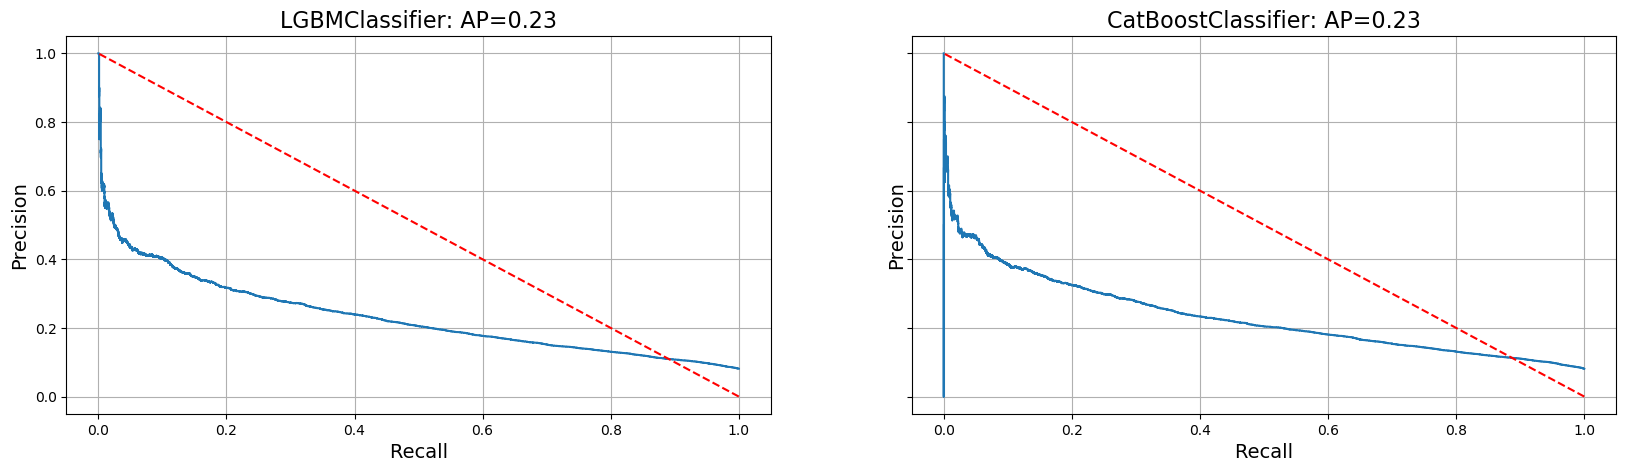

In [341]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
l_average_precision = metrics.average_precision_score(y_test, l_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, l_pred[:, 1])
ax1.step(recall, precision, where='post')
ax1.set_xlabel('Recall', fontsize=14)
ax1.set_ylabel('Precision', fontsize=14)
ax1.plot([1, 0], [0, 1],'r--')
ax1.set_title('LGBMClassifier: AP={0:0.2f}'.format(l_average_precision), fontsize=16)
ax1.grid()

cat_average_precision = metrics.average_precision_score(y_test, cat_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, cat_pred[:, 1])
ax2.step(recall, precision, where='post')
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.plot([1, 0], [0, 1],'r--')
ax2.set_title('CatBoostClassifier: AP={0:0.2f}'.format(cat_average_precision), fontsize=16)
ax2.grid()

In [344]:
print('LGBMClassifier: AP={0:0.6f}'.format(l_average_precision))
print('CatBoostClassifier: AP={0:0.6f}'.format(cat_average_precision))

LGBMClassifier: AP=0.231524
CatBoostClassifier: AP=0.232092


**Your answer here:** Качество CatBoostClassifier незначительно выше, чем LGBMClassifier. Возможно, это достигается за счет того, что CatBoost лучше борется с переобученностью модели. С другой стороны, оба алгоритма устроены примерно по одному принципу, поэтому точности их предсказаний не сильно отличаются.

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb).

**Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значения каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

Mean time: 14.179950213432312


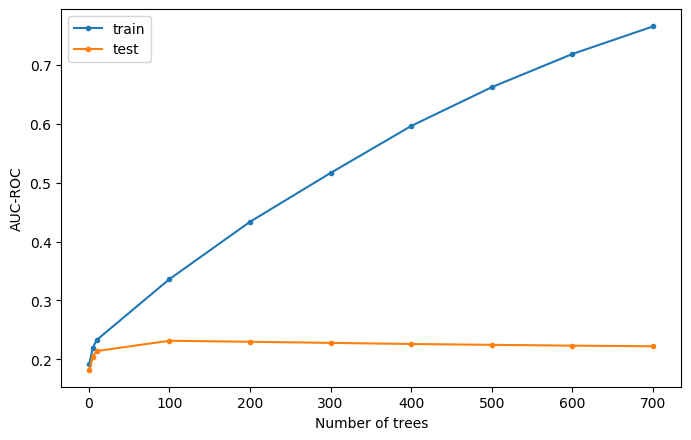

In [359]:
time_list = []

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    start_time = time.time()
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train[numeric_features], y_train)
    q_train = metrics.average_precision_score(y_train, clf.predict_proba(X_train[numeric_features])[:, 1])
    q_test = metrics.average_precision_score(y_test, clf.predict_proba(X_test[numeric_features])[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

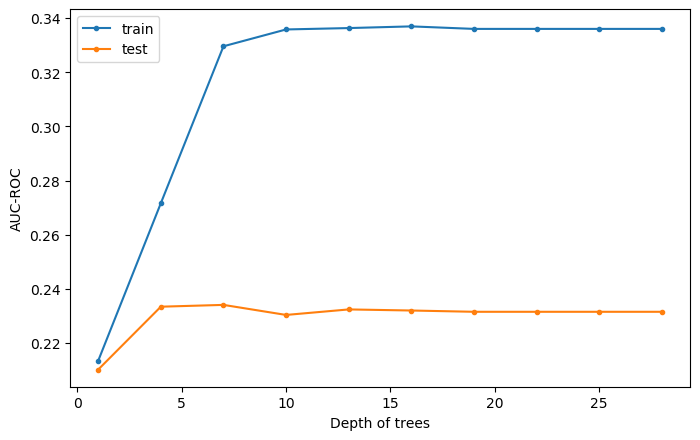

In [361]:
time_list = []

depth = list(range(1, 30, 3))
n_trees = n_trees[np.argmax(quals_test)]
quals_train = []
quals_test = []
for d in depth:
    start_time = time.time() 
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train[numeric_features], y_train)
    q_train = metrics.average_precision_score(y_train, lgb.predict_proba(X_train[numeric_features])[:, 1])
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(X_test[numeric_features])[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean time: 5.250996828079224


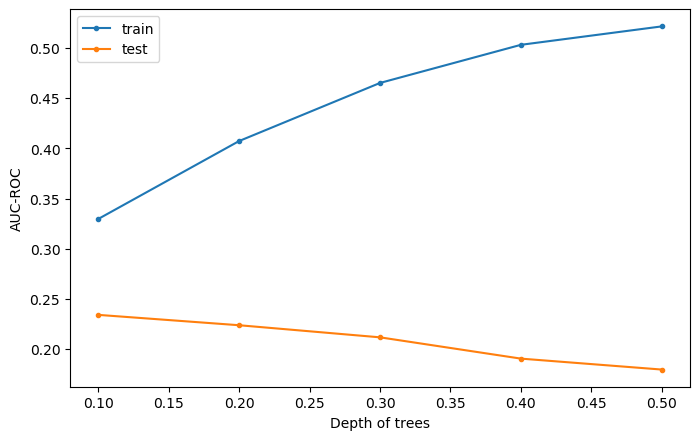

In [364]:
time_list = []

depth = depth[np.argmax(quals_test)]
learning_rate = np.arange(1, 6) / 10
quals_train = []
quals_test = []
for lr in learning_rate:
    start_time = time.time() 
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=depth, learning_rate=lr)
    lgb.fit(X_train[numeric_features], y_train)
    q_train = metrics.average_precision_score(y_train, lgb.predict_proba(X_train[numeric_features])[:, 1])
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(X_test[numeric_features])[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(8, 5))
plt.plot(learning_rate, quals_train, marker='.', label='train')
plt.plot(learning_rate, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [366]:
learning_rate = learning_rate[np.argmax(quals_test)]

print("Number of trees:", n_trees)
print("Max depth:", depth)
print("Learning rate:", learning_rate)

Number of trees: 100
Max depth: 7
Learning rate: 0.1


Learning rate set to 0.5
0:	learn: 0.3460078	total: 136ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3460078	total: 99.7ms	remaining: 399ms
1:	learn: 0.2780945	total: 222ms	remaining: 333ms
2:	learn: 0.2635156	total: 321ms	remaining: 214ms
3:	learn: 0.2570841	total: 408ms	remaining: 102ms
4:	learn: 0.2544861	total: 509ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3460078	total: 78.7ms	remaining: 708ms
1:	learn: 0.2780945	total: 161ms	remaining: 645ms
2:	learn: 0.2635156	total: 340ms	remaining: 793ms
3:	learn: 0.2570841	total: 455ms	remaining: 682ms
4:	learn: 0.2544861	total: 540ms	remaining: 540ms
5:	learn: 0.2532210	total: 651ms	remaining: 434ms
6:	learn: 0.2518581	total: 737ms	remaining: 316ms
7:	learn: 0.2511588	total: 832ms	remaining: 208ms
8:	learn: 0.2507129	total: 913ms	remaining: 101ms
9:	learn: 0.2500017	total: 1.02s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3460078	total: 81ms	remaining: 8.02s
1:	learn: 0.2780945	total: 165ms	remaining: 8.08s
2:	le

44:	learn: 0.2419120	total: 5.3s	remaining: 18.3s
45:	learn: 0.2416821	total: 5.42s	remaining: 18.1s
46:	learn: 0.2414025	total: 5.54s	remaining: 18s
47:	learn: 0.2412227	total: 5.66s	remaining: 17.9s
48:	learn: 0.2409829	total: 5.81s	remaining: 17.9s
49:	learn: 0.2408223	total: 5.94s	remaining: 17.8s
50:	learn: 0.2405622	total: 6.11s	remaining: 17.9s
51:	learn: 0.2402165	total: 6.26s	remaining: 17.8s
52:	learn: 0.2400431	total: 6.4s	remaining: 17.7s
53:	learn: 0.2399969	total: 6.54s	remaining: 17.7s
54:	learn: 0.2397506	total: 6.7s	remaining: 17.7s
55:	learn: 0.2394863	total: 6.88s	remaining: 17.7s
56:	learn: 0.2394661	total: 7.01s	remaining: 17.6s
57:	learn: 0.2392904	total: 7.14s	remaining: 17.5s
58:	learn: 0.2390506	total: 7.3s	remaining: 17.4s
59:	learn: 0.2388777	total: 7.53s	remaining: 17.6s
60:	learn: 0.2386869	total: 7.67s	remaining: 17.5s
61:	learn: 0.2384124	total: 7.83s	remaining: 17.4s
62:	learn: 0.2382353	total: 7.98s	remaining: 17.3s
63:	learn: 0.2380949	total: 8.1s	rema

4:	learn: 0.2722817	total: 519ms	remaining: 30.6s
5:	learn: 0.2651694	total: 651ms	remaining: 31.9s
6:	learn: 0.2606858	total: 771ms	remaining: 32.3s
7:	learn: 0.2578115	total: 889ms	remaining: 32.4s
8:	learn: 0.2562810	total: 998ms	remaining: 32.3s
9:	learn: 0.2549795	total: 1.1s	remaining: 31.8s
10:	learn: 0.2535443	total: 1.23s	remaining: 32.2s
11:	learn: 0.2526756	total: 1.33s	remaining: 32s
12:	learn: 0.2519452	total: 1.45s	remaining: 32.1s
13:	learn: 0.2515082	total: 1.57s	remaining: 32.1s
14:	learn: 0.2510386	total: 1.69s	remaining: 32s
15:	learn: 0.2507440	total: 1.82s	remaining: 32.3s
16:	learn: 0.2504268	total: 1.93s	remaining: 32.2s
17:	learn: 0.2499212	total: 2.04s	remaining: 32s
18:	learn: 0.2494020	total: 2.16s	remaining: 32s
19:	learn: 0.2490840	total: 2.28s	remaining: 31.9s
20:	learn: 0.2488486	total: 2.38s	remaining: 31.6s
21:	learn: 0.2485736	total: 2.48s	remaining: 31.3s
22:	learn: 0.2483433	total: 2.58s	remaining: 31.1s
23:	learn: 0.2481015	total: 2.67s	remaining: 3

165:	learn: 0.2284125	total: 17.6s	remaining: 14.2s
166:	learn: 0.2283358	total: 17.7s	remaining: 14.1s
167:	learn: 0.2282574	total: 17.8s	remaining: 14s
168:	learn: 0.2281206	total: 17.9s	remaining: 13.9s
169:	learn: 0.2279928	total: 18s	remaining: 13.7s
170:	learn: 0.2279455	total: 18.1s	remaining: 13.6s
171:	learn: 0.2278658	total: 18.1s	remaining: 13.5s
172:	learn: 0.2277705	total: 18.2s	remaining: 13.4s
173:	learn: 0.2276655	total: 18.3s	remaining: 13.3s
174:	learn: 0.2275140	total: 18.4s	remaining: 13.2s
175:	learn: 0.2274731	total: 18.5s	remaining: 13.1s
176:	learn: 0.2273202	total: 18.6s	remaining: 13s
177:	learn: 0.2271874	total: 18.7s	remaining: 12.8s
178:	learn: 0.2271000	total: 18.8s	remaining: 12.7s
179:	learn: 0.2269391	total: 18.9s	remaining: 12.6s
180:	learn: 0.2268233	total: 19s	remaining: 12.5s
181:	learn: 0.2266540	total: 19.1s	remaining: 12.4s
182:	learn: 0.2264998	total: 19.2s	remaining: 12.3s
183:	learn: 0.2264301	total: 19.3s	remaining: 12.2s
184:	learn: 0.226241

24:	learn: 0.2491352	total: 3.16s	remaining: 47.4s
25:	learn: 0.2489609	total: 3.3s	remaining: 47.5s
26:	learn: 0.2487953	total: 3.49s	remaining: 48.2s
27:	learn: 0.2486261	total: 3.62s	remaining: 48.1s
28:	learn: 0.2484303	total: 3.77s	remaining: 48.2s
29:	learn: 0.2482342	total: 3.96s	remaining: 48.8s
30:	learn: 0.2480845	total: 4.12s	remaining: 49s
31:	learn: 0.2479063	total: 4.23s	remaining: 48.7s
32:	learn: 0.2477774	total: 4.33s	remaining: 48.1s
33:	learn: 0.2475389	total: 4.47s	remaining: 48.1s
34:	learn: 0.2474068	total: 4.59s	remaining: 47.9s
35:	learn: 0.2471788	total: 4.75s	remaining: 48s
36:	learn: 0.2470488	total: 4.87s	remaining: 47.8s
37:	learn: 0.2469056	total: 4.99s	remaining: 47.6s
38:	learn: 0.2468181	total: 5.15s	remaining: 47.6s
39:	learn: 0.2467570	total: 5.29s	remaining: 47.6s
40:	learn: 0.2466026	total: 5.46s	remaining: 47.8s
41:	learn: 0.2464748	total: 5.59s	remaining: 47.7s
42:	learn: 0.2463324	total: 5.68s	remaining: 47.2s
43:	learn: 0.2462005	total: 5.77s	re

185:	learn: 0.2305315	total: 19.9s	remaining: 22.9s
186:	learn: 0.2304669	total: 20s	remaining: 22.8s
187:	learn: 0.2303444	total: 20.2s	remaining: 22.8s
188:	learn: 0.2302815	total: 20.3s	remaining: 22.7s
189:	learn: 0.2301665	total: 20.4s	remaining: 22.6s
190:	learn: 0.2300523	total: 20.5s	remaining: 22.5s
191:	learn: 0.2299770	total: 20.6s	remaining: 22.4s
192:	learn: 0.2298742	total: 20.7s	remaining: 22.2s
193:	learn: 0.2298352	total: 20.8s	remaining: 22.1s
194:	learn: 0.2297290	total: 20.9s	remaining: 22s
195:	learn: 0.2296472	total: 21s	remaining: 21.9s
196:	learn: 0.2295187	total: 21.1s	remaining: 21.7s
197:	learn: 0.2294237	total: 21.2s	remaining: 21.6s
198:	learn: 0.2293123	total: 21.3s	remaining: 21.5s
199:	learn: 0.2292586	total: 21.4s	remaining: 21.4s
200:	learn: 0.2291927	total: 21.5s	remaining: 21.3s
201:	learn: 0.2290552	total: 21.6s	remaining: 21.1s
202:	learn: 0.2289716	total: 21.6s	remaining: 21s
203:	learn: 0.2288376	total: 21.7s	remaining: 20.9s
204:	learn: 0.228759

345:	learn: 0.2172800	total: 36s	remaining: 5.62s
346:	learn: 0.2171877	total: 36.2s	remaining: 5.52s
347:	learn: 0.2170800	total: 36.3s	remaining: 5.42s
348:	learn: 0.2169880	total: 36.4s	remaining: 5.32s
349:	learn: 0.2169464	total: 36.5s	remaining: 5.21s
350:	learn: 0.2169035	total: 36.6s	remaining: 5.11s
351:	learn: 0.2168092	total: 36.7s	remaining: 5s
352:	learn: 0.2166984	total: 36.8s	remaining: 4.9s
353:	learn: 0.2166457	total: 37s	remaining: 4.8s
354:	learn: 0.2165717	total: 37.1s	remaining: 4.7s
355:	learn: 0.2164322	total: 37.2s	remaining: 4.6s
356:	learn: 0.2163166	total: 37.3s	remaining: 4.5s
357:	learn: 0.2162026	total: 37.4s	remaining: 4.39s
358:	learn: 0.2161277	total: 37.5s	remaining: 4.29s
359:	learn: 0.2161020	total: 37.6s	remaining: 4.18s
360:	learn: 0.2160180	total: 37.7s	remaining: 4.07s
361:	learn: 0.2159100	total: 37.8s	remaining: 3.97s
362:	learn: 0.2158116	total: 37.9s	remaining: 3.86s
363:	learn: 0.2157507	total: 38s	remaining: 3.76s
364:	learn: 0.2156796	tota

106:	learn: 0.2407233	total: 10.6s	remaining: 39s
107:	learn: 0.2406293	total: 10.7s	remaining: 39s
108:	learn: 0.2405067	total: 10.8s	remaining: 38.9s
109:	learn: 0.2404167	total: 10.9s	remaining: 38.8s
110:	learn: 0.2402993	total: 11s	remaining: 38.7s
111:	learn: 0.2402314	total: 11.1s	remaining: 38.6s
112:	learn: 0.2401808	total: 11.3s	remaining: 38.6s
113:	learn: 0.2400782	total: 11.4s	remaining: 38.5s
114:	learn: 0.2399881	total: 11.5s	remaining: 38.4s
115:	learn: 0.2399023	total: 11.6s	remaining: 38.3s
116:	learn: 0.2397599	total: 11.7s	remaining: 38.3s
117:	learn: 0.2396512	total: 11.8s	remaining: 38.2s
118:	learn: 0.2395542	total: 11.9s	remaining: 38.1s
119:	learn: 0.2394640	total: 12s	remaining: 37.9s
120:	learn: 0.2393701	total: 12.1s	remaining: 37.8s
121:	learn: 0.2392961	total: 12.2s	remaining: 37.7s
122:	learn: 0.2392449	total: 12.2s	remaining: 37.5s
123:	learn: 0.2391401	total: 12.4s	remaining: 37.5s
124:	learn: 0.2390367	total: 12.5s	remaining: 37.4s
125:	learn: 0.238935

266:	learn: 0.2282430	total: 29.4s	remaining: 25.7s
267:	learn: 0.2281801	total: 29.5s	remaining: 25.6s
268:	learn: 0.2281574	total: 29.6s	remaining: 25.4s
269:	learn: 0.2280641	total: 29.7s	remaining: 25.3s
270:	learn: 0.2280016	total: 29.8s	remaining: 25.2s
271:	learn: 0.2278915	total: 29.9s	remaining: 25.1s
272:	learn: 0.2278413	total: 30s	remaining: 25s
273:	learn: 0.2277412	total: 30.1s	remaining: 24.9s
274:	learn: 0.2276801	total: 30.2s	remaining: 24.7s
275:	learn: 0.2275602	total: 30.3s	remaining: 24.6s
276:	learn: 0.2275104	total: 30.5s	remaining: 24.5s
277:	learn: 0.2274213	total: 30.5s	remaining: 24.4s
278:	learn: 0.2273905	total: 30.6s	remaining: 24.3s
279:	learn: 0.2272846	total: 30.7s	remaining: 24.1s
280:	learn: 0.2271886	total: 30.8s	remaining: 24s
281:	learn: 0.2271048	total: 30.9s	remaining: 23.9s
282:	learn: 0.2270269	total: 31s	remaining: 23.8s
283:	learn: 0.2269421	total: 31.1s	remaining: 23.7s
284:	learn: 0.2268780	total: 31.2s	remaining: 23.6s
285:	learn: 0.226761

425:	learn: 0.2174293	total: 45.5s	remaining: 7.9s
426:	learn: 0.2173441	total: 45.6s	remaining: 7.8s
427:	learn: 0.2172626	total: 45.7s	remaining: 7.69s
428:	learn: 0.2171968	total: 45.8s	remaining: 7.58s
429:	learn: 0.2170767	total: 45.9s	remaining: 7.47s
430:	learn: 0.2170330	total: 46s	remaining: 7.36s
431:	learn: 0.2169411	total: 46.1s	remaining: 7.25s
432:	learn: 0.2169072	total: 46.2s	remaining: 7.15s
433:	learn: 0.2168545	total: 46.3s	remaining: 7.04s
434:	learn: 0.2167742	total: 46.4s	remaining: 6.93s
435:	learn: 0.2166959	total: 46.5s	remaining: 6.82s
436:	learn: 0.2166035	total: 46.6s	remaining: 6.71s
437:	learn: 0.2165378	total: 46.6s	remaining: 6.6s
438:	learn: 0.2164689	total: 46.8s	remaining: 6.5s
439:	learn: 0.2164215	total: 46.9s	remaining: 6.4s
440:	learn: 0.2163485	total: 47.1s	remaining: 6.3s
441:	learn: 0.2162976	total: 47.2s	remaining: 6.19s
442:	learn: 0.2162474	total: 47.3s	remaining: 6.08s
443:	learn: 0.2161756	total: 47.4s	remaining: 5.97s
444:	learn: 0.216068

86:	learn: 0.2441489	total: 8.67s	remaining: 51.1s
87:	learn: 0.2440510	total: 8.77s	remaining: 51s
88:	learn: 0.2439640	total: 8.85s	remaining: 50.8s
89:	learn: 0.2438809	total: 8.96s	remaining: 50.8s
90:	learn: 0.2437948	total: 9.11s	remaining: 51s
91:	learn: 0.2437090	total: 9.22s	remaining: 50.9s
92:	learn: 0.2436189	total: 9.31s	remaining: 50.8s
93:	learn: 0.2435379	total: 9.4s	remaining: 50.6s
94:	learn: 0.2434732	total: 9.49s	remaining: 50.4s
95:	learn: 0.2433718	total: 9.58s	remaining: 50.3s
96:	learn: 0.2432834	total: 9.67s	remaining: 50.1s
97:	learn: 0.2432589	total: 9.77s	remaining: 50s
98:	learn: 0.2431687	total: 9.87s	remaining: 50s
99:	learn: 0.2430764	total: 9.97s	remaining: 49.9s
100:	learn: 0.2429704	total: 10.1s	remaining: 49.8s
101:	learn: 0.2428834	total: 10.2s	remaining: 49.6s
102:	learn: 0.2427575	total: 10.3s	remaining: 49.6s
103:	learn: 0.2426770	total: 10.4s	remaining: 49.5s
104:	learn: 0.2425847	total: 10.5s	remaining: 49.4s
105:	learn: 0.2424929	total: 10.5s	

245:	learn: 0.2319136	total: 24.5s	remaining: 35.2s
246:	learn: 0.2318423	total: 24.6s	remaining: 35.1s
247:	learn: 0.2317868	total: 24.7s	remaining: 35s
248:	learn: 0.2317378	total: 24.8s	remaining: 34.9s
249:	learn: 0.2317045	total: 24.8s	remaining: 34.8s
250:	learn: 0.2316392	total: 24.9s	remaining: 34.7s
251:	learn: 0.2315719	total: 25s	remaining: 34.6s
252:	learn: 0.2315329	total: 25.1s	remaining: 34.4s
253:	learn: 0.2314818	total: 25.2s	remaining: 34.3s
254:	learn: 0.2314792	total: 25.3s	remaining: 34.2s
255:	learn: 0.2314203	total: 25.4s	remaining: 34.1s
256:	learn: 0.2313180	total: 25.5s	remaining: 34s
257:	learn: 0.2312671	total: 25.6s	remaining: 33.9s
258:	learn: 0.2311776	total: 25.7s	remaining: 33.8s
259:	learn: 0.2311228	total: 25.7s	remaining: 33.7s
260:	learn: 0.2310565	total: 25.8s	remaining: 33.6s
261:	learn: 0.2309855	total: 25.9s	remaining: 33.4s
262:	learn: 0.2309385	total: 26s	remaining: 33.3s
263:	learn: 0.2308750	total: 26.1s	remaining: 33.2s
264:	learn: 0.230839

405:	learn: 0.2225812	total: 40.6s	remaining: 19.4s
406:	learn: 0.2225271	total: 40.7s	remaining: 19.3s
407:	learn: 0.2224807	total: 40.9s	remaining: 19.2s
408:	learn: 0.2224012	total: 41s	remaining: 19.2s
409:	learn: 0.2223333	total: 41.2s	remaining: 19.1s
410:	learn: 0.2222610	total: 41.3s	remaining: 19s
411:	learn: 0.2222315	total: 41.4s	remaining: 18.9s
412:	learn: 0.2221913	total: 41.5s	remaining: 18.8s
413:	learn: 0.2221477	total: 41.6s	remaining: 18.7s
414:	learn: 0.2220853	total: 41.7s	remaining: 18.6s
415:	learn: 0.2220201	total: 41.8s	remaining: 18.5s
416:	learn: 0.2219374	total: 41.9s	remaining: 18.4s
417:	learn: 0.2218589	total: 42s	remaining: 18.3s
418:	learn: 0.2217738	total: 42.1s	remaining: 18.2s
419:	learn: 0.2217205	total: 42.2s	remaining: 18.1s
420:	learn: 0.2217020	total: 42.3s	remaining: 18s
421:	learn: 0.2216602	total: 42.4s	remaining: 17.9s
422:	learn: 0.2215938	total: 42.4s	remaining: 17.8s
423:	learn: 0.2215322	total: 42.5s	remaining: 17.7s
424:	learn: 0.221466

566:	learn: 0.2136431	total: 57.1s	remaining: 3.32s
567:	learn: 0.2136007	total: 57.2s	remaining: 3.22s
568:	learn: 0.2135482	total: 57.3s	remaining: 3.12s
569:	learn: 0.2134737	total: 57.4s	remaining: 3.02s
570:	learn: 0.2134228	total: 57.5s	remaining: 2.92s
571:	learn: 0.2133544	total: 57.6s	remaining: 2.82s
572:	learn: 0.2133058	total: 57.7s	remaining: 2.72s
573:	learn: 0.2132606	total: 57.8s	remaining: 2.62s
574:	learn: 0.2131774	total: 57.9s	remaining: 2.52s
575:	learn: 0.2131309	total: 58s	remaining: 2.42s
576:	learn: 0.2130900	total: 58.1s	remaining: 2.31s
577:	learn: 0.2130337	total: 58.2s	remaining: 2.21s
578:	learn: 0.2129902	total: 58.3s	remaining: 2.11s
579:	learn: 0.2129597	total: 58.3s	remaining: 2.01s
580:	learn: 0.2129289	total: 58.4s	remaining: 1.91s
581:	learn: 0.2128701	total: 58.5s	remaining: 1.81s
582:	learn: 0.2128070	total: 58.6s	remaining: 1.71s
583:	learn: 0.2127415	total: 58.7s	remaining: 1.61s
584:	learn: 0.2126887	total: 58.8s	remaining: 1.51s
585:	learn: 0.

125:	learn: 0.2422026	total: 15.6s	remaining: 1m 10s
126:	learn: 0.2421632	total: 15.7s	remaining: 1m 10s
127:	learn: 0.2421214	total: 15.9s	remaining: 1m 10s
128:	learn: 0.2420490	total: 16s	remaining: 1m 10s
129:	learn: 0.2419659	total: 16.1s	remaining: 1m 10s
130:	learn: 0.2419285	total: 16.2s	remaining: 1m 10s
131:	learn: 0.2418911	total: 16.3s	remaining: 1m 10s
132:	learn: 0.2418208	total: 16.4s	remaining: 1m 10s
133:	learn: 0.2417480	total: 16.5s	remaining: 1m 9s
134:	learn: 0.2417001	total: 16.6s	remaining: 1m 9s
135:	learn: 0.2415880	total: 16.7s	remaining: 1m 9s
136:	learn: 0.2414913	total: 16.8s	remaining: 1m 9s
137:	learn: 0.2414297	total: 16.9s	remaining: 1m 8s
138:	learn: 0.2414234	total: 17s	remaining: 1m 8s
139:	learn: 0.2413135	total: 17.1s	remaining: 1m 8s
140:	learn: 0.2412287	total: 17.2s	remaining: 1m 8s
141:	learn: 0.2411566	total: 17.2s	remaining: 1m 7s
142:	learn: 0.2410926	total: 17.3s	remaining: 1m 7s
143:	learn: 0.2410368	total: 17.4s	remaining: 1m 7s
144:	lea

285:	learn: 0.2320750	total: 33.2s	remaining: 48.1s
286:	learn: 0.2319921	total: 33.3s	remaining: 48s
287:	learn: 0.2319058	total: 33.4s	remaining: 47.8s
288:	learn: 0.2318682	total: 33.5s	remaining: 47.7s
289:	learn: 0.2318299	total: 33.6s	remaining: 47.5s
290:	learn: 0.2317838	total: 33.7s	remaining: 47.4s
291:	learn: 0.2317458	total: 33.8s	remaining: 47.2s
292:	learn: 0.2316953	total: 33.9s	remaining: 47.1s
293:	learn: 0.2316499	total: 34s	remaining: 46.9s
294:	learn: 0.2315588	total: 34.1s	remaining: 46.8s
295:	learn: 0.2315350	total: 34.2s	remaining: 46.6s
296:	learn: 0.2314679	total: 34.3s	remaining: 46.5s
297:	learn: 0.2314123	total: 34.4s	remaining: 46.3s
298:	learn: 0.2313728	total: 34.4s	remaining: 46.2s
299:	learn: 0.2313057	total: 34.5s	remaining: 46.1s
300:	learn: 0.2312499	total: 34.6s	remaining: 45.9s
301:	learn: 0.2312026	total: 34.7s	remaining: 45.8s
302:	learn: 0.2311597	total: 34.9s	remaining: 45.7s
303:	learn: 0.2310821	total: 35s	remaining: 45.6s
304:	learn: 0.2310

444:	learn: 0.2239263	total: 49.9s	remaining: 28.6s
445:	learn: 0.2238830	total: 50s	remaining: 28.5s
446:	learn: 0.2238205	total: 50.1s	remaining: 28.4s
447:	learn: 0.2237619	total: 50.2s	remaining: 28.3s
448:	learn: 0.2236808	total: 50.4s	remaining: 28.1s
449:	learn: 0.2236180	total: 50.5s	remaining: 28s
450:	learn: 0.2235465	total: 50.6s	remaining: 27.9s
451:	learn: 0.2234845	total: 50.7s	remaining: 27.8s
452:	learn: 0.2234568	total: 50.8s	remaining: 27.7s
453:	learn: 0.2233900	total: 50.8s	remaining: 27.5s
454:	learn: 0.2233170	total: 50.9s	remaining: 27.4s
455:	learn: 0.2232667	total: 51s	remaining: 27.3s
456:	learn: 0.2232331	total: 51.1s	remaining: 27.2s
457:	learn: 0.2231480	total: 51.2s	remaining: 27.1s
458:	learn: 0.2230735	total: 51.3s	remaining: 27s
459:	learn: 0.2230198	total: 51.4s	remaining: 26.8s
460:	learn: 0.2229660	total: 51.5s	remaining: 26.7s
461:	learn: 0.2229308	total: 51.6s	remaining: 26.6s
462:	learn: 0.2229000	total: 51.7s	remaining: 26.5s
463:	learn: 0.222868

604:	learn: 0.2158830	total: 1m 6s	remaining: 10.4s
605:	learn: 0.2158495	total: 1m 6s	remaining: 10.3s
606:	learn: 0.2158083	total: 1m 6s	remaining: 10.2s
607:	learn: 0.2157317	total: 1m 6s	remaining: 10.1s
608:	learn: 0.2156790	total: 1m 6s	remaining: 9.96s
609:	learn: 0.2156284	total: 1m 6s	remaining: 9.85s
610:	learn: 0.2155769	total: 1m 6s	remaining: 9.74s
611:	learn: 0.2155409	total: 1m 6s	remaining: 9.63s
612:	learn: 0.2155169	total: 1m 7s	remaining: 9.51s
613:	learn: 0.2154540	total: 1m 7s	remaining: 9.4s
614:	learn: 0.2154116	total: 1m 7s	remaining: 9.29s
615:	learn: 0.2153553	total: 1m 7s	remaining: 9.17s
616:	learn: 0.2152931	total: 1m 7s	remaining: 9.06s
617:	learn: 0.2152289	total: 1m 7s	remaining: 8.95s
618:	learn: 0.2151842	total: 1m 7s	remaining: 8.84s
619:	learn: 0.2151272	total: 1m 7s	remaining: 8.73s
620:	learn: 0.2150840	total: 1m 7s	remaining: 8.62s
621:	learn: 0.2150313	total: 1m 7s	remaining: 8.51s
622:	learn: 0.2149818	total: 1m 7s	remaining: 8.39s
623:	learn: 0

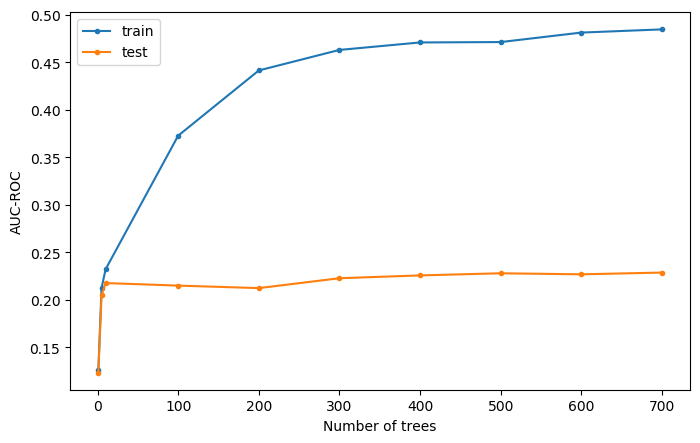

In [367]:
time_list = []

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    start_time = time.time()
    clf = CatBoostClassifier(n_estimators=n)
    clf.fit(X_train[numeric_features], y_train)
    q_train = metrics.average_precision_score(y_train, clf.predict_proba(X_train[numeric_features])[:, 1])
    q_test = metrics.average_precision_score(y_test, clf.predict_proba(X_test[numeric_features])[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Learning rate set to 0.259609
0:	learn: 0.4772529	total: 102ms	remaining: 30.4s
1:	learn: 0.3710615	total: 167ms	remaining: 24.9s
2:	learn: 0.3198756	total: 222ms	remaining: 21.9s
3:	learn: 0.2943574	total: 288ms	remaining: 21.3s
4:	learn: 0.2799268	total: 359ms	remaining: 21.2s
5:	learn: 0.2735670	total: 415ms	remaining: 20.4s
6:	learn: 0.2695698	total: 482ms	remaining: 20.2s
7:	learn: 0.2667769	total: 544ms	remaining: 19.8s
8:	learn: 0.2650097	total: 596ms	remaining: 19.3s
9:	learn: 0.2641474	total: 652ms	remaining: 18.9s
10:	learn: 0.2633055	total: 705ms	remaining: 18.5s
11:	learn: 0.2627659	total: 759ms	remaining: 18.2s
12:	learn: 0.2616718	total: 834ms	remaining: 18.4s
13:	learn: 0.2610456	total: 922ms	remaining: 18.8s
14:	learn: 0.2601933	total: 1.02s	remaining: 19.3s
15:	learn: 0.2597401	total: 1.11s	remaining: 19.7s
16:	learn: 0.2594906	total: 1.19s	remaining: 19.8s
17:	learn: 0.2589609	total: 1.26s	remaining: 19.8s
18:	learn: 0.2586014	total: 1.32s	remaining: 19.5s
19:	learn: 

162:	learn: 0.2497751	total: 10.3s	remaining: 8.68s
163:	learn: 0.2497589	total: 10.4s	remaining: 8.63s
164:	learn: 0.2497451	total: 10.5s	remaining: 8.59s
165:	learn: 0.2497291	total: 10.6s	remaining: 8.55s
166:	learn: 0.2497166	total: 10.7s	remaining: 8.49s
167:	learn: 0.2497031	total: 10.8s	remaining: 8.48s
168:	learn: 0.2496930	total: 10.9s	remaining: 8.43s
169:	learn: 0.2496770	total: 10.9s	remaining: 8.36s
170:	learn: 0.2496653	total: 11s	remaining: 8.28s
171:	learn: 0.2496511	total: 11s	remaining: 8.21s
172:	learn: 0.2496393	total: 11.1s	remaining: 8.14s
173:	learn: 0.2496277	total: 11.1s	remaining: 8.06s
174:	learn: 0.2496186	total: 11.2s	remaining: 8.01s
175:	learn: 0.2496103	total: 11.3s	remaining: 7.97s
176:	learn: 0.2495993	total: 11.4s	remaining: 7.91s
177:	learn: 0.2495955	total: 11.4s	remaining: 7.84s
178:	learn: 0.2495862	total: 11.5s	remaining: 7.78s
179:	learn: 0.2495788	total: 11.6s	remaining: 7.71s
180:	learn: 0.2495691	total: 11.6s	remaining: 7.64s
181:	learn: 0.24

21:	learn: 0.2522427	total: 1.64s	remaining: 20.7s
22:	learn: 0.2518801	total: 1.71s	remaining: 20.6s
23:	learn: 0.2517233	total: 1.78s	remaining: 20.5s
24:	learn: 0.2515388	total: 1.83s	remaining: 20.2s
25:	learn: 0.2513839	total: 1.92s	remaining: 20.2s
26:	learn: 0.2512775	total: 1.98s	remaining: 20s
27:	learn: 0.2511328	total: 2.04s	remaining: 19.9s
28:	learn: 0.2510150	total: 2.1s	remaining: 19.7s
29:	learn: 0.2508957	total: 2.18s	remaining: 19.6s
30:	learn: 0.2506751	total: 2.25s	remaining: 19.6s
31:	learn: 0.2505792	total: 2.33s	remaining: 19.5s
32:	learn: 0.2504786	total: 2.4s	remaining: 19.4s
33:	learn: 0.2503682	total: 2.46s	remaining: 19.3s
34:	learn: 0.2502932	total: 2.55s	remaining: 19.3s
35:	learn: 0.2501309	total: 2.62s	remaining: 19.2s
36:	learn: 0.2500664	total: 2.74s	remaining: 19.5s
37:	learn: 0.2499714	total: 2.82s	remaining: 19.4s
38:	learn: 0.2498999	total: 2.89s	remaining: 19.3s
39:	learn: 0.2497571	total: 2.95s	remaining: 19.2s
40:	learn: 0.2496779	total: 3.01s	r

182:	learn: 0.2429333	total: 16.3s	remaining: 10.4s
183:	learn: 0.2429083	total: 16.4s	remaining: 10.4s
184:	learn: 0.2428870	total: 16.6s	remaining: 10.3s
185:	learn: 0.2428470	total: 16.7s	remaining: 10.2s
186:	learn: 0.2428209	total: 16.8s	remaining: 10.1s
187:	learn: 0.2428201	total: 16.9s	remaining: 10s
188:	learn: 0.2427890	total: 17s	remaining: 9.96s
189:	learn: 0.2427683	total: 17s	remaining: 9.87s
190:	learn: 0.2427355	total: 17.1s	remaining: 9.77s
191:	learn: 0.2427083	total: 17.2s	remaining: 9.67s
192:	learn: 0.2426696	total: 17.3s	remaining: 9.58s
193:	learn: 0.2426374	total: 17.3s	remaining: 9.47s
194:	learn: 0.2425996	total: 17.4s	remaining: 9.39s
195:	learn: 0.2425731	total: 17.5s	remaining: 9.3s
196:	learn: 0.2425517	total: 17.6s	remaining: 9.21s
197:	learn: 0.2425322	total: 17.7s	remaining: 9.14s
198:	learn: 0.2425016	total: 17.9s	remaining: 9.07s
199:	learn: 0.2424710	total: 18s	remaining: 8.99s
200:	learn: 0.2424396	total: 18.1s	remaining: 8.9s
201:	learn: 0.2424112	

41:	learn: 0.2469971	total: 4.51s	remaining: 27.7s
42:	learn: 0.2468885	total: 4.59s	remaining: 27.5s
43:	learn: 0.2467924	total: 4.68s	remaining: 27.2s
44:	learn: 0.2466926	total: 4.78s	remaining: 27.1s
45:	learn: 0.2466123	total: 4.87s	remaining: 26.9s
46:	learn: 0.2465281	total: 4.96s	remaining: 26.7s
47:	learn: 0.2463664	total: 5.05s	remaining: 26.5s
48:	learn: 0.2462349	total: 5.14s	remaining: 26.3s
49:	learn: 0.2461349	total: 5.24s	remaining: 26.2s
50:	learn: 0.2459991	total: 5.32s	remaining: 26s
51:	learn: 0.2459308	total: 5.42s	remaining: 25.8s
52:	learn: 0.2458417	total: 5.51s	remaining: 25.7s
53:	learn: 0.2456781	total: 5.62s	remaining: 25.6s
54:	learn: 0.2455158	total: 5.7s	remaining: 25.4s
55:	learn: 0.2453371	total: 5.8s	remaining: 25.3s
56:	learn: 0.2451748	total: 5.91s	remaining: 25.2s
57:	learn: 0.2450503	total: 6.01s	remaining: 25.1s
58:	learn: 0.2449266	total: 6.11s	remaining: 25s
59:	learn: 0.2447740	total: 6.21s	remaining: 24.9s
60:	learn: 0.2447144	total: 6.31s	rem

201:	learn: 0.2324437	total: 22.8s	remaining: 11s
202:	learn: 0.2324001	total: 22.9s	remaining: 10.9s
203:	learn: 0.2323043	total: 23s	remaining: 10.8s
204:	learn: 0.2322050	total: 23.2s	remaining: 10.8s
205:	learn: 0.2321505	total: 23.3s	remaining: 10.6s
206:	learn: 0.2320278	total: 23.4s	remaining: 10.5s
207:	learn: 0.2319532	total: 23.6s	remaining: 10.4s
208:	learn: 0.2319047	total: 23.7s	remaining: 10.3s
209:	learn: 0.2318061	total: 23.9s	remaining: 10.2s
210:	learn: 0.2317326	total: 24s	remaining: 10.1s
211:	learn: 0.2316626	total: 24s	remaining: 9.98s
212:	learn: 0.2315806	total: 24.1s	remaining: 9.86s
213:	learn: 0.2315496	total: 24.2s	remaining: 9.74s
214:	learn: 0.2314459	total: 24.3s	remaining: 9.62s
215:	learn: 0.2313452	total: 24.4s	remaining: 9.5s
216:	learn: 0.2312579	total: 24.6s	remaining: 9.41s
217:	learn: 0.2311927	total: 24.7s	remaining: 9.3s
218:	learn: 0.2310970	total: 24.8s	remaining: 9.18s
219:	learn: 0.2310075	total: 24.9s	remaining: 9.07s
220:	learn: 0.2309389	

61:	learn: 0.2380254	total: 9.58s	remaining: 36.8s
62:	learn: 0.2379479	total: 9.7s	remaining: 36.5s
63:	learn: 0.2376801	total: 9.86s	remaining: 36.4s
64:	learn: 0.2374517	total: 10s	remaining: 36.2s
65:	learn: 0.2372867	total: 10.2s	remaining: 36.1s
66:	learn: 0.2370716	total: 10.3s	remaining: 35.9s
67:	learn: 0.2368294	total: 10.5s	remaining: 35.7s
68:	learn: 0.2366094	total: 10.6s	remaining: 35.4s
69:	learn: 0.2364021	total: 10.7s	remaining: 35.2s
70:	learn: 0.2361478	total: 10.8s	remaining: 35s
71:	learn: 0.2360448	total: 11s	remaining: 34.7s
72:	learn: 0.2356744	total: 11.1s	remaining: 34.6s
73:	learn: 0.2355263	total: 11.3s	remaining: 34.5s
74:	learn: 0.2352622	total: 11.4s	remaining: 34.3s
75:	learn: 0.2349541	total: 11.6s	remaining: 34.1s
76:	learn: 0.2346221	total: 11.7s	remaining: 34s
77:	learn: 0.2343754	total: 11.9s	remaining: 33.8s
78:	learn: 0.2341907	total: 12s	remaining: 33.6s
79:	learn: 0.2340914	total: 12.2s	remaining: 33.4s
80:	learn: 0.2338240	total: 12.3s	remainin

222:	learn: 0.2105224	total: 33.3s	remaining: 11.5s
223:	learn: 0.2103730	total: 33.4s	remaining: 11.3s
224:	learn: 0.2102085	total: 33.6s	remaining: 11.2s
225:	learn: 0.2099732	total: 33.7s	remaining: 11s
226:	learn: 0.2098535	total: 33.8s	remaining: 10.9s
227:	learn: 0.2096332	total: 34s	remaining: 10.7s
228:	learn: 0.2095108	total: 34.1s	remaining: 10.6s
229:	learn: 0.2094452	total: 34.2s	remaining: 10.4s
230:	learn: 0.2092376	total: 34.3s	remaining: 10.3s
231:	learn: 0.2091774	total: 34.4s	remaining: 10.1s
232:	learn: 0.2089593	total: 34.6s	remaining: 9.95s
233:	learn: 0.2088515	total: 34.7s	remaining: 9.79s
234:	learn: 0.2087748	total: 34.8s	remaining: 9.63s
235:	learn: 0.2086738	total: 34.9s	remaining: 9.47s
236:	learn: 0.2085952	total: 35.1s	remaining: 9.32s
237:	learn: 0.2085287	total: 35.2s	remaining: 9.16s
238:	learn: 0.2083097	total: 35.3s	remaining: 9.01s
239:	learn: 0.2082353	total: 35.4s	remaining: 8.86s
240:	learn: 0.2081466	total: 35.6s	remaining: 8.71s
241:	learn: 0.20

82:	learn: 0.2149292	total: 21.4s	remaining: 56s
83:	learn: 0.2142991	total: 21.7s	remaining: 55.8s
84:	learn: 0.2139799	total: 21.9s	remaining: 55.5s
85:	learn: 0.2135055	total: 22.3s	remaining: 55.4s
86:	learn: 0.2131054	total: 22.5s	remaining: 55s
87:	learn: 0.2129827	total: 22.7s	remaining: 54.7s
88:	learn: 0.2125015	total: 22.9s	remaining: 54.4s
89:	learn: 0.2121859	total: 23.2s	remaining: 54.1s
90:	learn: 0.2116734	total: 23.4s	remaining: 53.8s
91:	learn: 0.2114384	total: 23.6s	remaining: 53.4s
92:	learn: 0.2107964	total: 23.9s	remaining: 53.1s
93:	learn: 0.2106230	total: 24.1s	remaining: 52.8s
94:	learn: 0.2103769	total: 24.3s	remaining: 52.4s
95:	learn: 0.2100276	total: 24.5s	remaining: 52.1s
96:	learn: 0.2097589	total: 24.8s	remaining: 51.8s
97:	learn: 0.2090866	total: 25s	remaining: 51.6s
98:	learn: 0.2084675	total: 25.3s	remaining: 51.3s
99:	learn: 0.2081416	total: 25.5s	remaining: 51s
100:	learn: 0.2079680	total: 25.7s	remaining: 50.7s
101:	learn: 0.2077847	total: 25.9s	rem

241:	learn: 0.1652463	total: 1m 4s	remaining: 15.5s
242:	learn: 0.1649439	total: 1m 5s	remaining: 15.3s
243:	learn: 0.1647675	total: 1m 5s	remaining: 15s
244:	learn: 0.1644569	total: 1m 5s	remaining: 14.8s
245:	learn: 0.1642056	total: 1m 6s	remaining: 14.5s
246:	learn: 0.1640191	total: 1m 6s	remaining: 14.2s
247:	learn: 0.1638416	total: 1m 6s	remaining: 14s
248:	learn: 0.1636584	total: 1m 7s	remaining: 13.7s
249:	learn: 0.1631779	total: 1m 7s	remaining: 13.5s
250:	learn: 0.1628992	total: 1m 7s	remaining: 13.2s
251:	learn: 0.1627992	total: 1m 8s	remaining: 13s
252:	learn: 0.1624777	total: 1m 8s	remaining: 12.7s
253:	learn: 0.1622564	total: 1m 8s	remaining: 12.4s
254:	learn: 0.1620454	total: 1m 9s	remaining: 12.2s
255:	learn: 0.1616427	total: 1m 9s	remaining: 11.9s
256:	learn: 0.1612815	total: 1m 9s	remaining: 11.7s
257:	learn: 0.1609192	total: 1m 10s	remaining: 11.4s
258:	learn: 0.1607814	total: 1m 10s	remaining: 11.2s
259:	learn: 0.1606166	total: 1m 10s	remaining: 10.9s
260:	learn: 0.1

98:	learn: 0.1638403	total: 1m 26s	remaining: 2m 56s
99:	learn: 0.1633056	total: 1m 27s	remaining: 2m 55s
100:	learn: 0.1627650	total: 1m 29s	remaining: 2m 55s
101:	learn: 0.1625529	total: 1m 30s	remaining: 2m 55s
102:	learn: 0.1618101	total: 1m 31s	remaining: 2m 54s
103:	learn: 0.1613529	total: 1m 32s	remaining: 2m 53s
104:	learn: 0.1608940	total: 1m 32s	remaining: 2m 52s
105:	learn: 0.1605166	total: 1m 33s	remaining: 2m 51s
106:	learn: 0.1597221	total: 1m 34s	remaining: 2m 49s
107:	learn: 0.1592655	total: 1m 34s	remaining: 2m 48s
108:	learn: 0.1587563	total: 1m 35s	remaining: 2m 47s
109:	learn: 0.1579110	total: 1m 36s	remaining: 2m 46s
110:	learn: 0.1573344	total: 1m 37s	remaining: 2m 45s
111:	learn: 0.1563445	total: 1m 38s	remaining: 2m 44s
112:	learn: 0.1557273	total: 1m 38s	remaining: 2m 43s
113:	learn: 0.1550732	total: 1m 39s	remaining: 2m 42s
114:	learn: 0.1543948	total: 1m 40s	remaining: 2m 41s
115:	learn: 0.1538949	total: 1m 40s	remaining: 2m 40s
116:	learn: 0.1532067	total: 1

252:	learn: 0.0848035	total: 3m 37s	remaining: 40.5s
253:	learn: 0.0840544	total: 3m 38s	remaining: 39.6s
254:	learn: 0.0835507	total: 3m 39s	remaining: 38.7s
255:	learn: 0.0833371	total: 3m 40s	remaining: 37.9s
256:	learn: 0.0830620	total: 3m 41s	remaining: 37s
257:	learn: 0.0828719	total: 3m 41s	remaining: 36.1s
258:	learn: 0.0826083	total: 3m 42s	remaining: 35.2s
259:	learn: 0.0824831	total: 3m 43s	remaining: 34.4s
260:	learn: 0.0823468	total: 3m 44s	remaining: 33.5s
261:	learn: 0.0821011	total: 3m 45s	remaining: 32.7s
262:	learn: 0.0817938	total: 3m 46s	remaining: 31.8s
263:	learn: 0.0815324	total: 3m 47s	remaining: 31s
264:	learn: 0.0812274	total: 3m 47s	remaining: 30.1s
265:	learn: 0.0809143	total: 3m 48s	remaining: 29.2s
266:	learn: 0.0808938	total: 3m 49s	remaining: 28.4s
267:	learn: 0.0806857	total: 3m 50s	remaining: 27.5s
268:	learn: 0.0804188	total: 3m 50s	remaining: 26.6s
269:	learn: 0.0801311	total: 3m 51s	remaining: 25.8s
270:	learn: 0.0795834	total: 3m 52s	remaining: 24.

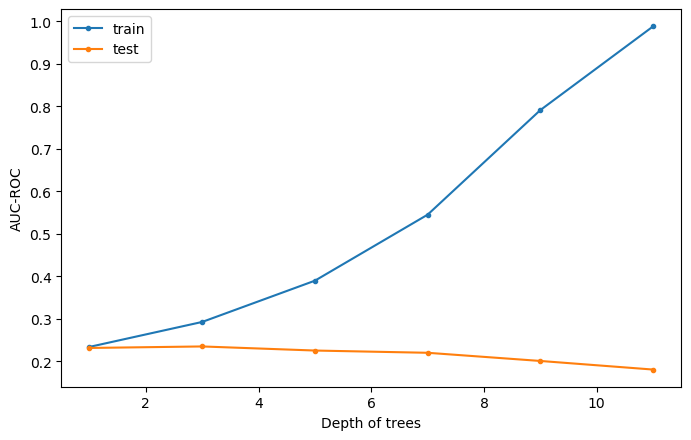

In [370]:
time_list = []

depth = list(range(1, 12, 2))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    start_time = time.time() 
    lgb = CatBoostClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train[numeric_features], y_train)
    q_train = metrics.average_precision_score(y_train, lgb.predict_proba(X_train[numeric_features])[:, 1])
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(X_test[numeric_features])[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

0:	learn: 0.5948663	total: 39ms	remaining: 11.7s
1:	learn: 0.5188163	total: 79.2ms	remaining: 11.8s
2:	learn: 0.4640755	total: 118ms	remaining: 11.7s
3:	learn: 0.4169542	total: 157ms	remaining: 11.6s
4:	learn: 0.3836432	total: 203ms	remaining: 12s
5:	learn: 0.3568531	total: 265ms	remaining: 13s
6:	learn: 0.3371753	total: 323ms	remaining: 13.5s
7:	learn: 0.3205762	total: 369ms	remaining: 13.5s
8:	learn: 0.3084139	total: 412ms	remaining: 13.3s
9:	learn: 0.2992745	total: 468ms	remaining: 13.6s
10:	learn: 0.2908625	total: 536ms	remaining: 14.1s
11:	learn: 0.2844646	total: 588ms	remaining: 14.1s
12:	learn: 0.2801240	total: 634ms	remaining: 14s
13:	learn: 0.2759018	total: 695ms	remaining: 14.2s
14:	learn: 0.2730175	total: 746ms	remaining: 14.2s
15:	learn: 0.2704330	total: 801ms	remaining: 14.2s
16:	learn: 0.2678269	total: 853ms	remaining: 14.2s
17:	learn: 0.2659046	total: 910ms	remaining: 14.3s
18:	learn: 0.2643252	total: 981ms	remaining: 14.5s
19:	learn: 0.2629982	total: 1.03s	remaining: 14

163:	learn: 0.2478369	total: 8.19s	remaining: 6.79s
164:	learn: 0.2478047	total: 8.24s	remaining: 6.74s
165:	learn: 0.2477584	total: 8.29s	remaining: 6.69s
166:	learn: 0.2477376	total: 8.34s	remaining: 6.64s
167:	learn: 0.2477188	total: 8.38s	remaining: 6.59s
168:	learn: 0.2476946	total: 8.45s	remaining: 6.55s
169:	learn: 0.2476795	total: 8.49s	remaining: 6.49s
170:	learn: 0.2476618	total: 8.53s	remaining: 6.44s
171:	learn: 0.2476267	total: 8.58s	remaining: 6.38s
172:	learn: 0.2475893	total: 8.63s	remaining: 6.33s
173:	learn: 0.2475670	total: 8.67s	remaining: 6.28s
174:	learn: 0.2475307	total: 8.72s	remaining: 6.23s
175:	learn: 0.2475109	total: 8.76s	remaining: 6.17s
176:	learn: 0.2474899	total: 8.81s	remaining: 6.13s
177:	learn: 0.2474738	total: 8.87s	remaining: 6.08s
178:	learn: 0.2474566	total: 8.92s	remaining: 6.03s
179:	learn: 0.2474373	total: 8.97s	remaining: 5.98s
180:	learn: 0.2474228	total: 9.02s	remaining: 5.93s
181:	learn: 0.2474064	total: 9.06s	remaining: 5.87s
182:	learn: 

26:	learn: 0.2524462	total: 1.68s	remaining: 17s
27:	learn: 0.2522721	total: 1.73s	remaining: 16.9s
28:	learn: 0.2520885	total: 1.8s	remaining: 16.8s
29:	learn: 0.2519187	total: 1.86s	remaining: 16.8s
30:	learn: 0.2518125	total: 1.92s	remaining: 16.6s
31:	learn: 0.2517381	total: 1.97s	remaining: 16.5s
32:	learn: 0.2516358	total: 2.02s	remaining: 16.3s
33:	learn: 0.2513692	total: 2.07s	remaining: 16.2s
34:	learn: 0.2512372	total: 2.13s	remaining: 16.1s
35:	learn: 0.2511354	total: 2.17s	remaining: 15.9s
36:	learn: 0.2508947	total: 2.22s	remaining: 15.8s
37:	learn: 0.2508349	total: 2.26s	remaining: 15.6s
38:	learn: 0.2507632	total: 2.33s	remaining: 15.6s
39:	learn: 0.2506599	total: 2.4s	remaining: 15.6s
40:	learn: 0.2506231	total: 2.46s	remaining: 15.6s
41:	learn: 0.2504938	total: 2.54s	remaining: 15.6s
42:	learn: 0.2504089	total: 2.6s	remaining: 15.6s
43:	learn: 0.2503423	total: 2.65s	remaining: 15.4s
44:	learn: 0.2502791	total: 2.7s	remaining: 15.3s
45:	learn: 0.2501818	total: 2.77s	rem

189:	learn: 0.2441895	total: 11.8s	remaining: 6.81s
190:	learn: 0.2441536	total: 11.8s	remaining: 6.75s
191:	learn: 0.2441158	total: 11.9s	remaining: 6.7s
192:	learn: 0.2440925	total: 12s	remaining: 6.64s
193:	learn: 0.2440851	total: 12.1s	remaining: 6.59s
194:	learn: 0.2440642	total: 12.1s	remaining: 6.54s
195:	learn: 0.2440306	total: 12.2s	remaining: 6.47s
196:	learn: 0.2439890	total: 12.3s	remaining: 6.41s
197:	learn: 0.2439484	total: 12.3s	remaining: 6.35s
198:	learn: 0.2439138	total: 12.4s	remaining: 6.3s
199:	learn: 0.2438869	total: 12.5s	remaining: 6.24s
200:	learn: 0.2438645	total: 12.6s	remaining: 6.2s
201:	learn: 0.2438381	total: 12.6s	remaining: 6.13s
202:	learn: 0.2438078	total: 12.7s	remaining: 6.07s
203:	learn: 0.2437707	total: 12.8s	remaining: 6.01s
204:	learn: 0.2437477	total: 12.8s	remaining: 5.93s
205:	learn: 0.2437265	total: 12.8s	remaining: 5.86s
206:	learn: 0.2437049	total: 12.9s	remaining: 5.79s
207:	learn: 0.2436698	total: 12.9s	remaining: 5.73s
208:	learn: 0.243

50:	learn: 0.2482426	total: 2.41s	remaining: 11.8s
51:	learn: 0.2481164	total: 2.47s	remaining: 11.8s
52:	learn: 0.2480424	total: 2.52s	remaining: 11.7s
53:	learn: 0.2480026	total: 2.56s	remaining: 11.7s
54:	learn: 0.2479529	total: 2.61s	remaining: 11.6s
55:	learn: 0.2478660	total: 2.65s	remaining: 11.6s
56:	learn: 0.2478188	total: 2.73s	remaining: 11.6s
57:	learn: 0.2477158	total: 2.77s	remaining: 11.6s
58:	learn: 0.2476221	total: 2.83s	remaining: 11.6s
59:	learn: 0.2475587	total: 2.89s	remaining: 11.6s
60:	learn: 0.2474893	total: 2.93s	remaining: 11.5s
61:	learn: 0.2474352	total: 3s	remaining: 11.5s
62:	learn: 0.2473618	total: 3.04s	remaining: 11.5s
63:	learn: 0.2473124	total: 3.09s	remaining: 11.4s
64:	learn: 0.2472571	total: 3.13s	remaining: 11.3s
65:	learn: 0.2471897	total: 3.17s	remaining: 11.3s
66:	learn: 0.2471275	total: 3.22s	remaining: 11.2s
67:	learn: 0.2470705	total: 3.27s	remaining: 11.2s
68:	learn: 0.2469620	total: 3.31s	remaining: 11.1s
69:	learn: 0.2469062	total: 3.35s	

213:	learn: 0.2407923	total: 10.5s	remaining: 4.2s
214:	learn: 0.2407607	total: 10.5s	remaining: 4.15s
215:	learn: 0.2407428	total: 10.5s	remaining: 4.1s
216:	learn: 0.2407172	total: 10.6s	remaining: 4.05s
217:	learn: 0.2406788	total: 10.6s	remaining: 4s
218:	learn: 0.2406477	total: 10.7s	remaining: 3.95s
219:	learn: 0.2405879	total: 10.7s	remaining: 3.9s
220:	learn: 0.2405476	total: 10.8s	remaining: 3.85s
221:	learn: 0.2404832	total: 10.8s	remaining: 3.8s
222:	learn: 0.2404369	total: 10.9s	remaining: 3.75s
223:	learn: 0.2403997	total: 10.9s	remaining: 3.7s
224:	learn: 0.2403758	total: 11s	remaining: 3.65s
225:	learn: 0.2403371	total: 11s	remaining: 3.6s
226:	learn: 0.2402999	total: 11.1s	remaining: 3.56s
227:	learn: 0.2402666	total: 11.1s	remaining: 3.5s
228:	learn: 0.2402297	total: 11.1s	remaining: 3.45s
229:	learn: 0.2401964	total: 11.2s	remaining: 3.41s
230:	learn: 0.2401503	total: 11.2s	remaining: 3.36s
231:	learn: 0.2401016	total: 11.3s	remaining: 3.31s
232:	learn: 0.2400561	tota

74:	learn: 0.2460014	total: 4.29s	remaining: 12.9s
75:	learn: 0.2458856	total: 4.34s	remaining: 12.8s
76:	learn: 0.2458300	total: 4.38s	remaining: 12.7s
77:	learn: 0.2457570	total: 4.42s	remaining: 12.6s
78:	learn: 0.2457089	total: 4.47s	remaining: 12.5s
79:	learn: 0.2456626	total: 4.53s	remaining: 12.5s
80:	learn: 0.2455922	total: 4.57s	remaining: 12.4s
81:	learn: 0.2454709	total: 4.61s	remaining: 12.3s
82:	learn: 0.2454217	total: 4.66s	remaining: 12.2s
83:	learn: 0.2453527	total: 4.7s	remaining: 12.1s
84:	learn: 0.2452809	total: 4.74s	remaining: 12s
85:	learn: 0.2451376	total: 4.79s	remaining: 11.9s
86:	learn: 0.2450601	total: 4.84s	remaining: 11.9s
87:	learn: 0.2449855	total: 4.89s	remaining: 11.8s
88:	learn: 0.2449040	total: 4.93s	remaining: 11.7s
89:	learn: 0.2448241	total: 4.98s	remaining: 11.6s
90:	learn: 0.2447716	total: 5.03s	remaining: 11.5s
91:	learn: 0.2447194	total: 5.06s	remaining: 11.4s
92:	learn: 0.2446501	total: 5.11s	remaining: 11.4s
93:	learn: 0.2446063	total: 5.15s	

236:	learn: 0.2377409	total: 12.3s	remaining: 3.28s
237:	learn: 0.2377137	total: 12.4s	remaining: 3.22s
238:	learn: 0.2376744	total: 12.4s	remaining: 3.17s
239:	learn: 0.2376401	total: 12.4s	remaining: 3.11s
240:	learn: 0.2375995	total: 12.5s	remaining: 3.06s
241:	learn: 0.2375661	total: 12.5s	remaining: 3s
242:	learn: 0.2375285	total: 12.6s	remaining: 2.95s
243:	learn: 0.2374888	total: 12.6s	remaining: 2.9s
244:	learn: 0.2374443	total: 12.7s	remaining: 2.84s
245:	learn: 0.2374107	total: 12.7s	remaining: 2.79s
246:	learn: 0.2373827	total: 12.8s	remaining: 2.74s
247:	learn: 0.2373527	total: 12.8s	remaining: 2.69s
248:	learn: 0.2373209	total: 12.9s	remaining: 2.64s
249:	learn: 0.2372976	total: 12.9s	remaining: 2.59s
250:	learn: 0.2372602	total: 13s	remaining: 2.53s
251:	learn: 0.2372052	total: 13s	remaining: 2.48s
252:	learn: 0.2371511	total: 13.1s	remaining: 2.43s
253:	learn: 0.2371102	total: 13.1s	remaining: 2.38s
254:	learn: 0.2370786	total: 13.2s	remaining: 2.33s
255:	learn: 0.237057

98:	learn: 0.2434488	total: 4.61s	remaining: 9.35s
99:	learn: 0.2433744	total: 4.67s	remaining: 9.34s
100:	learn: 0.2432967	total: 4.73s	remaining: 9.32s
101:	learn: 0.2432375	total: 4.8s	remaining: 9.31s
102:	learn: 0.2431700	total: 4.86s	remaining: 9.29s
103:	learn: 0.2431034	total: 4.92s	remaining: 9.27s
104:	learn: 0.2430455	total: 4.98s	remaining: 9.24s
105:	learn: 0.2429411	total: 5.03s	remaining: 9.2s
106:	learn: 0.2428804	total: 5.07s	remaining: 9.14s
107:	learn: 0.2428079	total: 5.12s	remaining: 9.1s
108:	learn: 0.2427528	total: 5.16s	remaining: 9.04s
109:	learn: 0.2427166	total: 5.2s	remaining: 8.98s
110:	learn: 0.2426621	total: 5.25s	remaining: 8.94s
111:	learn: 0.2426184	total: 5.29s	remaining: 8.88s
112:	learn: 0.2425566	total: 5.33s	remaining: 8.82s
113:	learn: 0.2425101	total: 5.37s	remaining: 8.76s
114:	learn: 0.2424375	total: 5.41s	remaining: 8.7s
115:	learn: 0.2423894	total: 5.45s	remaining: 8.64s
116:	learn: 0.2423010	total: 5.5s	remaining: 8.6s
117:	learn: 0.2422487

259:	learn: 0.2348521	total: 11.8s	remaining: 1.81s
260:	learn: 0.2348027	total: 11.8s	remaining: 1.77s
261:	learn: 0.2347591	total: 11.9s	remaining: 1.72s
262:	learn: 0.2347392	total: 11.9s	remaining: 1.68s
263:	learn: 0.2347089	total: 12s	remaining: 1.63s
264:	learn: 0.2346849	total: 12s	remaining: 1.58s
265:	learn: 0.2346040	total: 12s	remaining: 1.54s
266:	learn: 0.2345808	total: 12.1s	remaining: 1.49s
267:	learn: 0.2345251	total: 12.1s	remaining: 1.45s
268:	learn: 0.2344979	total: 12.2s	remaining: 1.4s
269:	learn: 0.2344572	total: 12.2s	remaining: 1.36s
270:	learn: 0.2344141	total: 12.3s	remaining: 1.31s
271:	learn: 0.2343858	total: 12.3s	remaining: 1.27s
272:	learn: 0.2343408	total: 12.4s	remaining: 1.22s
273:	learn: 0.2343158	total: 12.4s	remaining: 1.18s
274:	learn: 0.2342495	total: 12.4s	remaining: 1.13s
275:	learn: 0.2341900	total: 12.5s	remaining: 1.09s
276:	learn: 0.2341277	total: 12.5s	remaining: 1.04s
277:	learn: 0.2340939	total: 12.6s	remaining: 996ms
278:	learn: 0.23405

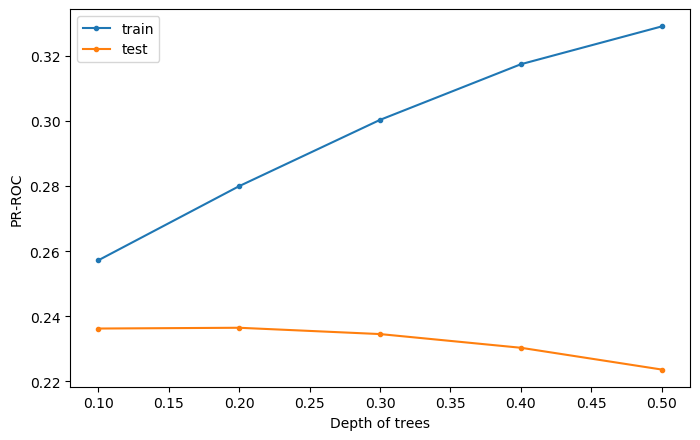

In [371]:
time_list = []

depth = depth[np.argmax(quals_test)]
eta = np.arange(1, 6) / 10
quals_train = []
quals_test = []
for e in eta:
    start_time = time.time()
    lgb = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, eta=e)
    lgb.fit(X_train[numeric_features], y_train)
    q_train = metrics.average_precision_score(y_train, lgb.predict_proba(X_train[numeric_features])[:, 1])
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(X_test[numeric_features])[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(8, 5))
plt.plot(eta, quals_train, marker='.', label='train')
plt.plot(eta, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('PR-ROC')
plt.legend()

plt.show()

In [372]:
eta = eta[np.argmax(quals_test)]

print("Number of trees:", n_trees)
print("Max depth:", depth)
print("Learning rate:", eta)

Number of trees: 300
Max depth: 3
Learning rate: 0.2


**Your answer here:** Итак, для LGBMClassifier получаем 100 деревьев глубины 7, для CatBoostClasifier 300 деревьев высоты 3. Т.е. LGBM строит меньше деревьев, но они большей глубины. Каждая отдельная модель сложнее, но совокупное количество алгоритмов меньше. А CatBoost больше деревьев меньшей глубины. Промежуточные модели проще (об этом говорится в описании алгоритма: он строит небрежные деревья).

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

In [23]:
%%time

enc = OneHotEncoder(handle_unknown = "ignore")
X_categor_train = enc.fit_transform(X_train[categorical]).toarray()
X_categor_test = enc.transform(X_test[categorical]).toarray()

encode_X_train = X_train.drop(columns=categorical)
encode_X_test = X_test.drop(columns=categorical)

encode_X_train = np.hstack((encode_X_train.to_numpy(), X_categor_train))
encode_X_test = np.hstack((encode_X_test.to_numpy(), X_categor_test))

Wall time: 3.39 s


In [387]:
%%time

model = LGBMClassifier(max_depth=7, n_estimators=100)
model.fit(encode_X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 4.15 s


LGBMClassifier(max_depth=7)

In [388]:
%%time

cat = CatBoostClassifier(max_depth=3, n_estimators=300, eta=0.2)
cat.fit(encode_X_train, y_train)

0:	learn: 0.5133118	total: 48.5ms	remaining: 14.5s
1:	learn: 0.4146176	total: 91.9ms	remaining: 13.7s
2:	learn: 0.3540076	total: 138ms	remaining: 13.7s
3:	learn: 0.3156921	total: 178ms	remaining: 13.2s
4:	learn: 0.2937180	total: 221ms	remaining: 13s
5:	learn: 0.2817051	total: 278ms	remaining: 13.6s
6:	learn: 0.2740153	total: 346ms	remaining: 14.5s
7:	learn: 0.2683996	total: 398ms	remaining: 14.5s
8:	learn: 0.2647069	total: 446ms	remaining: 14.4s
9:	learn: 0.2613937	total: 502ms	remaining: 14.6s
10:	learn: 0.2598343	total: 558ms	remaining: 14.7s
11:	learn: 0.2583841	total: 602ms	remaining: 14.5s
12:	learn: 0.2573428	total: 659ms	remaining: 14.5s
13:	learn: 0.2564754	total: 707ms	remaining: 14.5s
14:	learn: 0.2559869	total: 765ms	remaining: 14.5s
15:	learn: 0.2556027	total: 803ms	remaining: 14.3s
16:	learn: 0.2551417	total: 849ms	remaining: 14.1s
17:	learn: 0.2546861	total: 896ms	remaining: 14s
18:	learn: 0.2542550	total: 955ms	remaining: 14.1s
19:	learn: 0.2537562	total: 1s	remaining: 1

163:	learn: 0.2430447	total: 7.99s	remaining: 6.62s
164:	learn: 0.2430205	total: 8.03s	remaining: 6.57s
165:	learn: 0.2429620	total: 8.08s	remaining: 6.52s
166:	learn: 0.2429364	total: 8.12s	remaining: 6.47s
167:	learn: 0.2428840	total: 8.18s	remaining: 6.42s
168:	learn: 0.2428368	total: 8.23s	remaining: 6.38s
169:	learn: 0.2427909	total: 8.28s	remaining: 6.33s
170:	learn: 0.2427635	total: 8.33s	remaining: 6.29s
171:	learn: 0.2427304	total: 8.39s	remaining: 6.25s
172:	learn: 0.2427059	total: 8.44s	remaining: 6.2s
173:	learn: 0.2426843	total: 8.49s	remaining: 6.15s
174:	learn: 0.2426573	total: 8.54s	remaining: 6.1s
175:	learn: 0.2426265	total: 8.6s	remaining: 6.06s
176:	learn: 0.2425985	total: 8.66s	remaining: 6.01s
177:	learn: 0.2425756	total: 8.72s	remaining: 5.97s
178:	learn: 0.2425436	total: 8.78s	remaining: 5.94s
179:	learn: 0.2425229	total: 8.83s	remaining: 5.89s
180:	learn: 0.2424996	total: 8.88s	remaining: 5.84s
181:	learn: 0.2424734	total: 8.93s	remaining: 5.79s
182:	learn: 0.2

In [389]:
l_pred = model.predict_proba(encode_X_test)
cat_pred = cat.predict_proba(encode_X_test)

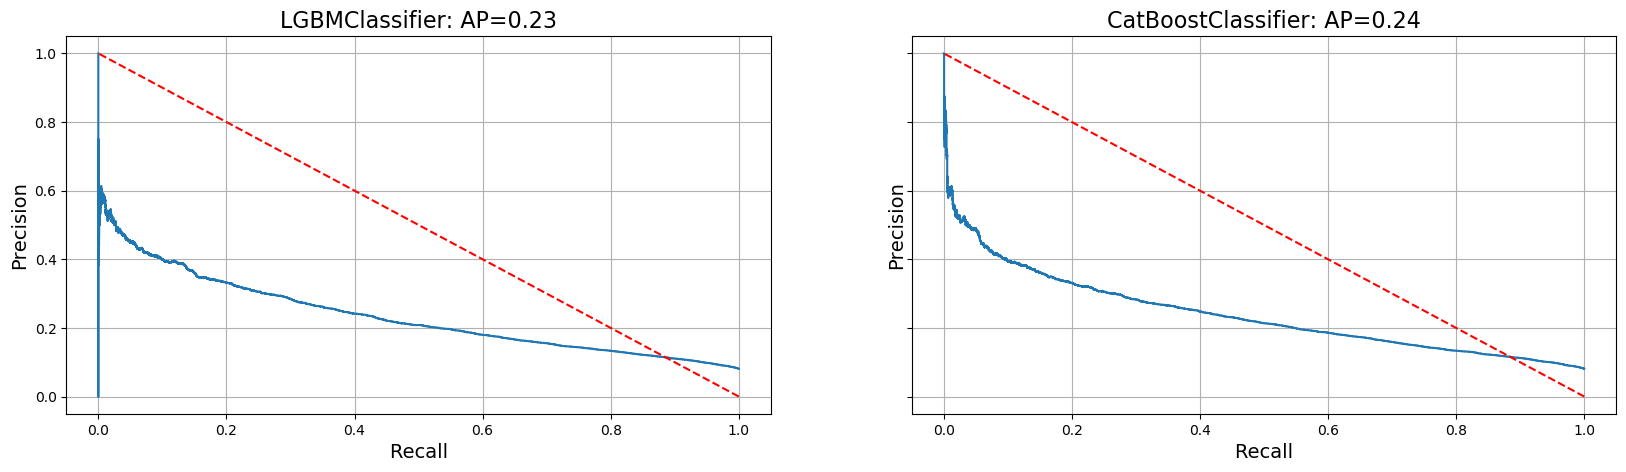

In [390]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
l_average_precision = metrics.average_precision_score(y_test, l_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, l_pred[:, 1])
ax1.step(recall, precision, where='post')
ax1.set_xlabel('Recall', fontsize=14)
ax1.set_ylabel('Precision', fontsize=14)
ax1.plot([1, 0], [0, 1],'r--')
ax1.set_title('LGBMClassifier: AP={0:0.2f}'.format(l_average_precision), fontsize=16)
ax1.grid()

cat_average_precision = metrics.average_precision_score(y_test, cat_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, cat_pred[:, 1])
ax2.step(recall, precision, where='post')
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.plot([1, 0], [0, 1],'r--')
ax2.set_title('CatBoostClassifier: AP={0:0.2f}'.format(cat_average_precision), fontsize=16)
ax2.grid()

In [391]:
print('LGBMClassifier: AP={0:0.6f}'.format(l_average_precision))
print('CatBoostClassifier: AP={0:0.6f}'.format(cat_average_precision))

LGBMClassifier: AP=0.234775
CatBoostClassifier: AP=0.239812


In [127]:
%%time
encoder = ce.CountEncoder(cols=categorical)

count_X_train = encoder.fit_transform(X_train, y_train)
count_X_test = encoder.transform(X_test, y_train)

Wall time: 2.97 s


In [128]:
%%time

model = LGBMClassifier(max_depth=7, n_estimators=100)
model.fit(count_X_train, y_train)

Wall time: 7.26 s


LGBMClassifier(max_depth=7)

In [129]:
%%time

cat = CatBoostClassifier(max_depth=3, n_estimators=300, eta=0.2)
cat.fit(count_X_train, y_train)

0:	learn: 0.5104480	total: 104ms	remaining: 31.2s
1:	learn: 0.4079917	total: 257ms	remaining: 38.2s
2:	learn: 0.3535043	total: 382ms	remaining: 37.8s
3:	learn: 0.3192724	total: 462ms	remaining: 34.2s
4:	learn: 0.2950750	total: 557ms	remaining: 32.8s
5:	learn: 0.2833542	total: 637ms	remaining: 31.2s
6:	learn: 0.2750715	total: 704ms	remaining: 29.5s
7:	learn: 0.2692933	total: 783ms	remaining: 28.6s
8:	learn: 0.2654356	total: 853ms	remaining: 27.6s
9:	learn: 0.2621336	total: 918ms	remaining: 26.6s
10:	learn: 0.2602197	total: 1s	remaining: 26.4s
11:	learn: 0.2590217	total: 1.06s	remaining: 25.5s
12:	learn: 0.2578751	total: 1.15s	remaining: 25.3s
13:	learn: 0.2570132	total: 1.22s	remaining: 24.8s
14:	learn: 0.2561534	total: 1.29s	remaining: 24.6s
15:	learn: 0.2554736	total: 1.35s	remaining: 24s
16:	learn: 0.2548844	total: 1.42s	remaining: 23.7s
17:	learn: 0.2543830	total: 1.5s	remaining: 23.4s
18:	learn: 0.2539465	total: 1.57s	remaining: 23.2s
19:	learn: 0.2537076	total: 1.63s	remaining: 22

162:	learn: 0.2432430	total: 12.6s	remaining: 10.6s
163:	learn: 0.2432102	total: 12.7s	remaining: 10.5s
164:	learn: 0.2431904	total: 12.8s	remaining: 10.5s
165:	learn: 0.2431594	total: 12.9s	remaining: 10.4s
166:	learn: 0.2431351	total: 12.9s	remaining: 10.3s
167:	learn: 0.2430918	total: 13s	remaining: 10.2s
168:	learn: 0.2430632	total: 13.1s	remaining: 10.1s
169:	learn: 0.2430275	total: 13.2s	remaining: 10.1s
170:	learn: 0.2429960	total: 13.2s	remaining: 9.99s
171:	learn: 0.2429717	total: 13.3s	remaining: 9.92s
172:	learn: 0.2429308	total: 13.4s	remaining: 9.84s
173:	learn: 0.2429062	total: 13.5s	remaining: 9.77s
174:	learn: 0.2428839	total: 13.6s	remaining: 9.7s
175:	learn: 0.2428566	total: 13.7s	remaining: 9.62s
176:	learn: 0.2428367	total: 13.7s	remaining: 9.55s
177:	learn: 0.2427913	total: 13.8s	remaining: 9.47s
178:	learn: 0.2427579	total: 13.9s	remaining: 9.38s
179:	learn: 0.2427220	total: 13.9s	remaining: 9.3s
180:	learn: 0.2426906	total: 14s	remaining: 9.22s
181:	learn: 0.2426

In [130]:
l_pred = model.predict_proba(count_X_test)
cat_pred = cat.predict_proba(count_X_test)

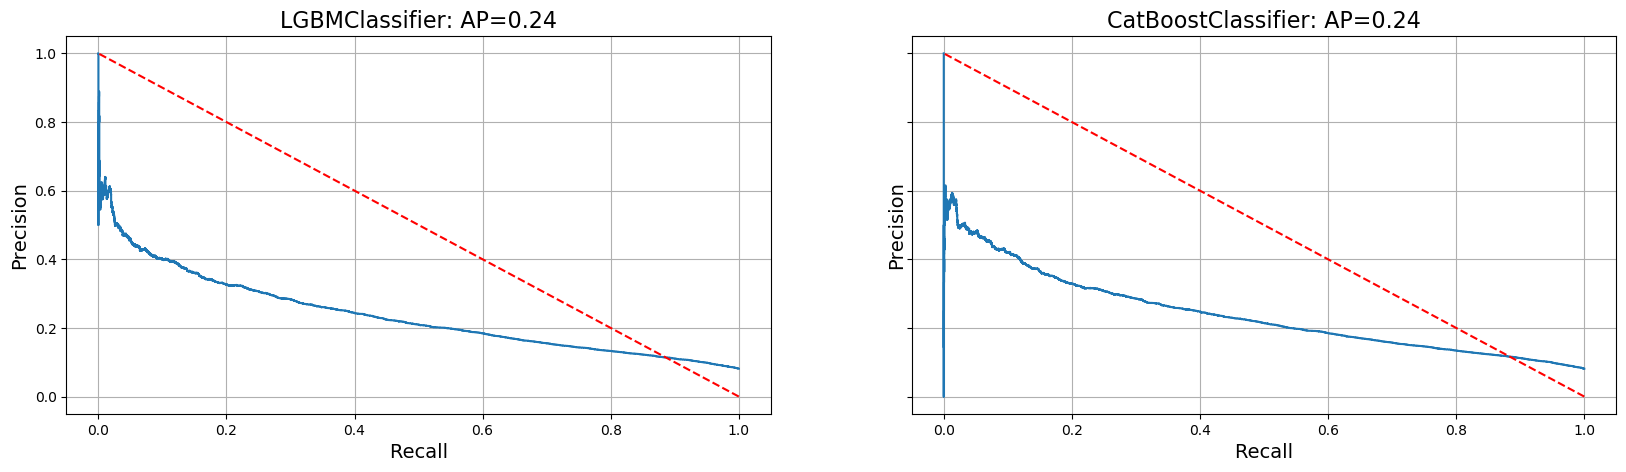

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
l_average_precision = metrics.average_precision_score(y_test, l_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, l_pred[:, 1])
ax1.step(recall, precision, where='post')
ax1.set_xlabel('Recall', fontsize=14)
ax1.set_ylabel('Precision', fontsize=14)
ax1.plot([1, 0], [0, 1],'r--')
ax1.set_title('LGBMClassifier: AP={0:0.2f}'.format(l_average_precision), fontsize=16)
ax1.grid()

cat_average_precision = metrics.average_precision_score(y_test, cat_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, cat_pred[:, 1])
ax2.step(recall, precision, where='post')
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.plot([1, 0], [0, 1],'r--')
ax2.set_title('CatBoostClassifier: AP={0:0.2f}'.format(cat_average_precision), fontsize=16)
ax2.grid()

In [132]:
print('LGBMClassifier: AP={0:0.6f}'.format(l_average_precision))
print('CatBoostClassifier: AP={0:0.6f}'.format(cat_average_precision))

LGBMClassifier: AP=0.236872
CatBoostClassifier: AP=0.238806


Мы получили, что для LGBM лучше использовать счетчики, т.к. они показывают лучшее качество предсказания, а для CatBoost OHE-кодирование. Что касается времени обучения алгоритма, на предсказание при кодировании счетчиками уходит большее количество времени, чем на предсказание при OHE-кодировании. При этом само OHE-кодирование занимает больше времени, чем кодирование счетчиками.

**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [114]:
%%time

cat = CatBoostClassifier(max_depth=3, n_estimators=300, eta=0.2, cat_features=categorical)
cat.fit(X_train, y_train)

0:	learn: 0.5122894	total: 349ms	remaining: 1m 44s
1:	learn: 0.4039765	total: 569ms	remaining: 1m 24s
2:	learn: 0.3497760	total: 757ms	remaining: 1m 14s
3:	learn: 0.3156340	total: 942ms	remaining: 1m 9s
4:	learn: 0.2956596	total: 1.14s	remaining: 1m 6s
5:	learn: 0.2816508	total: 1.32s	remaining: 1m 4s
6:	learn: 0.2732467	total: 1.52s	remaining: 1m 3s
7:	learn: 0.2679061	total: 1.7s	remaining: 1m 2s
8:	learn: 0.2642795	total: 1.89s	remaining: 1m
9:	learn: 0.2618140	total: 2.06s	remaining: 59.9s
10:	learn: 0.2599816	total: 2.24s	remaining: 58.8s
11:	learn: 0.2584896	total: 2.42s	remaining: 58.2s
12:	learn: 0.2573614	total: 2.61s	remaining: 57.5s
13:	learn: 0.2564669	total: 2.79s	remaining: 57.1s
14:	learn: 0.2559900	total: 2.98s	remaining: 56.7s
15:	learn: 0.2555246	total: 3.17s	remaining: 56.3s
16:	learn: 0.2548740	total: 3.37s	remaining: 56.1s
17:	learn: 0.2542893	total: 3.55s	remaining: 55.6s
18:	learn: 0.2539439	total: 3.72s	remaining: 55s
19:	learn: 0.2536824	total: 3.95s	remaining:

161:	learn: 0.2434855	total: 31.9s	remaining: 27.2s
162:	learn: 0.2434588	total: 32.1s	remaining: 27s
163:	learn: 0.2434309	total: 32.3s	remaining: 26.8s
164:	learn: 0.2434065	total: 32.5s	remaining: 26.6s
165:	learn: 0.2433395	total: 32.7s	remaining: 26.4s
166:	learn: 0.2432828	total: 32.9s	remaining: 26.2s
167:	learn: 0.2432667	total: 33.2s	remaining: 26.1s
168:	learn: 0.2432407	total: 33.5s	remaining: 25.9s
169:	learn: 0.2432226	total: 33.8s	remaining: 25.8s
170:	learn: 0.2431959	total: 34s	remaining: 25.7s
171:	learn: 0.2431847	total: 34.3s	remaining: 25.5s
172:	learn: 0.2431701	total: 34.6s	remaining: 25.4s
173:	learn: 0.2431353	total: 34.9s	remaining: 25.3s
174:	learn: 0.2431069	total: 35.1s	remaining: 25.1s
175:	learn: 0.2430788	total: 35.3s	remaining: 24.9s
176:	learn: 0.2430505	total: 35.5s	remaining: 24.7s
177:	learn: 0.2430475	total: 35.7s	remaining: 24.5s
178:	learn: 0.2430457	total: 35.9s	remaining: 24.3s
179:	learn: 0.2430191	total: 36.1s	remaining: 24.1s
180:	learn: 0.24

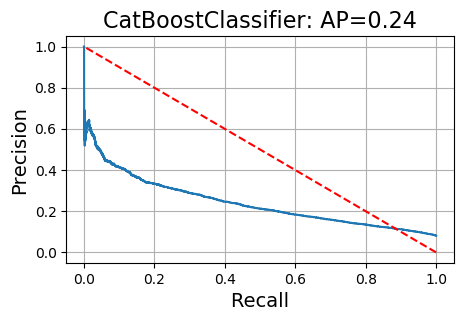

In [117]:
cat_pred = cat.predict_proba(X_test)

fig, ax2 = plt.subplots(1, 1, figsize=(5, 3))
cat_average_precision = metrics.average_precision_score(y_test, cat_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, cat_pred[:, 1])
ax2.step(recall, precision, where='post')
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.plot([1, 0], [0, 1],'r--')
ax2.set_title('CatBoostClassifier: AP={0:0.2f}'.format(cat_average_precision), fontsize=16)
ax2.grid()

In [118]:
print('CatBoostClassifier: AP={0:0.6f}'.format(cat_average_precision))

CatBoostClassifier: AP=0.242033


Время обучения модели выросло в три раза, т.к. теперь внутри CatBoost происходит обработка категориальных признаков, на что уходит определенное количество времени. Зато теперь качество выросло на 0.004 по сравнению с ОНЕ-кодированием.

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

Mean time: 12.27759313583374


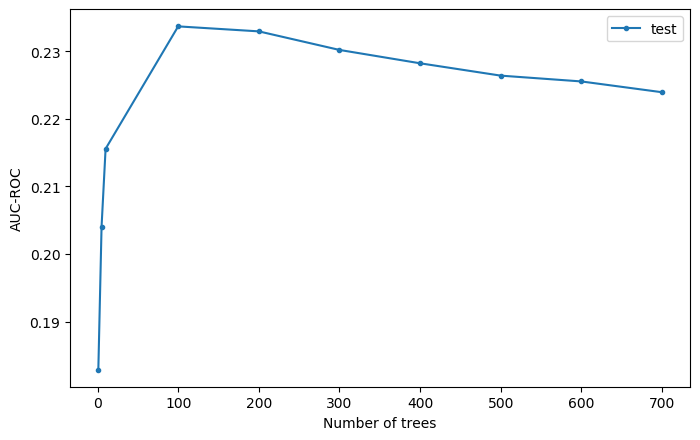

In [133]:
time_list = []

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_test = []
for n in n_trees:
    start_time = time.time()
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(count_X_train, y_train)
    q_test = metrics.average_precision_score(y_test, clf.predict_proba(count_X_test)[:, 1])
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(7, 5))
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

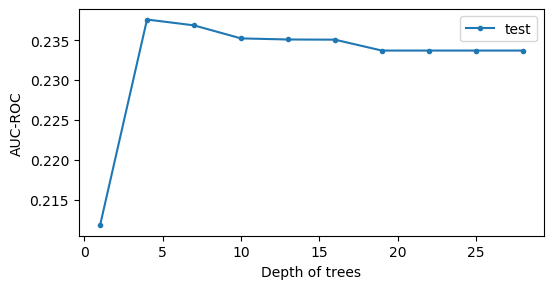

In [136]:
time_list = []

depth = list(range(1, 30, 3))
n_trees = n_trees[np.argmax(quals_test)]
quals_test = []
for d in depth:
    start_time = time.time() 
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(count_X_train, y_train)
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(count_X_test)[:, 1])
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(6, 3))
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Mean time: 5.856615829467773


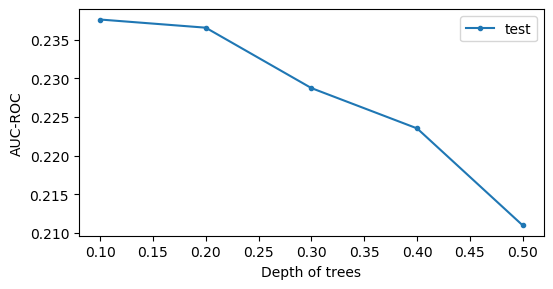

In [137]:
time_list = []

depth = depth[np.argmax(quals_test)]
learning_rate = np.arange(1, 6) / 10
quals_test = []
for lr in learning_rate:
    start_time = time.time() 
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=depth, learning_rate=lr)
    lgb.fit(count_X_train, y_train)
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(count_X_test)[:, 1])
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(6, 3))
plt.plot(learning_rate, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [138]:
learning_rate = learning_rate[np.argmax(quals_test)]

print("Number of trees:", n_trees)
print("Max depth:", depth)
print("Learning rate:", learning_rate)

Number of trees: 100
Max depth: 4
Learning rate: 0.1


Learning rate set to 0.5
0:	learn: 0.3476953	total: 401ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3476953	total: 372ms	remaining: 1.49s
1:	learn: 0.2778983	total: 696ms	remaining: 1.04s
2:	learn: 0.2628325	total: 1.03s	remaining: 688ms
3:	learn: 0.2559503	total: 1.38s	remaining: 345ms
4:	learn: 0.2533887	total: 1.69s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3476953	total: 321ms	remaining: 2.88s
1:	learn: 0.2778983	total: 580ms	remaining: 2.32s
2:	learn: 0.2628325	total: 958ms	remaining: 2.23s
3:	learn: 0.2559503	total: 1.3s	remaining: 1.96s
4:	learn: 0.2533887	total: 1.62s	remaining: 1.62s
5:	learn: 0.2522554	total: 1.9s	remaining: 1.26s
6:	learn: 0.2507847	total: 2.24s	remaining: 959ms
7:	learn: 0.2495846	total: 2.51s	remaining: 627ms
8:	learn: 0.2486710	total: 2.8s	remaining: 312ms
9:	learn: 0.2479815	total: 3.08s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3476953	total: 334ms	remaining: 33s
1:	learn: 0.2778983	total: 629ms	remaining: 30.8s
2:	learn: 0

44:	learn: 0.2401991	total: 31s	remaining: 1m 46s
45:	learn: 0.2399677	total: 31.6s	remaining: 1m 45s
46:	learn: 0.2396790	total: 32.4s	remaining: 1m 45s
47:	learn: 0.2395529	total: 33s	remaining: 1m 44s
48:	learn: 0.2393345	total: 33.6s	remaining: 1m 43s
49:	learn: 0.2393226	total: 34.6s	remaining: 1m 43s
50:	learn: 0.2390920	total: 35.3s	remaining: 1m 43s
51:	learn: 0.2388805	total: 36s	remaining: 1m 42s
52:	learn: 0.2387773	total: 36.7s	remaining: 1m 41s
53:	learn: 0.2386373	total: 37.3s	remaining: 1m 40s
54:	learn: 0.2384355	total: 38s	remaining: 1m 40s
55:	learn: 0.2381558	total: 38.7s	remaining: 1m 39s
56:	learn: 0.2379932	total: 39.4s	remaining: 1m 38s
57:	learn: 0.2377865	total: 40.1s	remaining: 1m 38s
58:	learn: 0.2375893	total: 40.6s	remaining: 1m 37s
59:	learn: 0.2374237	total: 41.2s	remaining: 1m 36s
60:	learn: 0.2373121	total: 41.9s	remaining: 1m 35s
61:	learn: 0.2372385	total: 42.6s	remaining: 1m 34s
62:	learn: 0.2370735	total: 43.4s	remaining: 1m 34s
63:	learn: 0.2369736

1:	learn: 0.3625145	total: 1.63s	remaining: 4m 2s
2:	learn: 0.3121159	total: 2.38s	remaining: 3m 55s
3:	learn: 0.2855652	total: 3.1s	remaining: 3m 49s
4:	learn: 0.2720863	total: 3.84s	remaining: 3m 46s
5:	learn: 0.2654447	total: 4.58s	remaining: 3m 44s
6:	learn: 0.2600039	total: 5.29s	remaining: 3m 41s
7:	learn: 0.2571761	total: 5.89s	remaining: 3m 34s
8:	learn: 0.2556260	total: 6.59s	remaining: 3m 33s
9:	learn: 0.2539267	total: 7.33s	remaining: 3m 32s
10:	learn: 0.2525391	total: 8.01s	remaining: 3m 30s
11:	learn: 0.2515875	total: 8.72s	remaining: 3m 29s
12:	learn: 0.2508785	total: 9.61s	remaining: 3m 32s
13:	learn: 0.2502659	total: 10.4s	remaining: 3m 32s
14:	learn: 0.2498200	total: 11.1s	remaining: 3m 31s
15:	learn: 0.2493724	total: 11.8s	remaining: 3m 30s
16:	learn: 0.2489583	total: 12.6s	remaining: 3m 29s
17:	learn: 0.2485023	total: 13.3s	remaining: 3m 28s
18:	learn: 0.2480394	total: 14s	remaining: 3m 27s
19:	learn: 0.2477431	total: 14.8s	remaining: 3m 27s
20:	learn: 0.2475052	tota

158:	learn: 0.2302358	total: 1m 51s	remaining: 1m 38s
159:	learn: 0.2300874	total: 1m 51s	remaining: 1m 37s
160:	learn: 0.2299509	total: 1m 52s	remaining: 1m 37s
161:	learn: 0.2298504	total: 1m 53s	remaining: 1m 36s
162:	learn: 0.2297616	total: 1m 54s	remaining: 1m 35s
163:	learn: 0.2297139	total: 1m 54s	remaining: 1m 35s
164:	learn: 0.2296680	total: 1m 55s	remaining: 1m 34s
165:	learn: 0.2295742	total: 1m 56s	remaining: 1m 33s
166:	learn: 0.2295389	total: 1m 56s	remaining: 1m 32s
167:	learn: 0.2294404	total: 1m 57s	remaining: 1m 32s
168:	learn: 0.2293390	total: 1m 58s	remaining: 1m 31s
169:	learn: 0.2291943	total: 1m 58s	remaining: 1m 30s
170:	learn: 0.2290470	total: 1m 59s	remaining: 1m 30s
171:	learn: 0.2289602	total: 2m	remaining: 1m 29s
172:	learn: 0.2288466	total: 2m	remaining: 1m 28s
173:	learn: 0.2287511	total: 2m 1s	remaining: 1m 28s
174:	learn: 0.2286856	total: 2m 2s	remaining: 1m 27s
175:	learn: 0.2285930	total: 2m 3s	remaining: 1m 26s
176:	learn: 0.2284881	total: 2m 3s	rema

13:	learn: 0.2528085	total: 10.3s	remaining: 4m 44s
14:	learn: 0.2520027	total: 11s	remaining: 4m 43s
15:	learn: 0.2513880	total: 11.8s	remaining: 4m 42s
16:	learn: 0.2509294	total: 12.5s	remaining: 4m 41s
17:	learn: 0.2504172	total: 13.2s	remaining: 4m 40s
18:	learn: 0.2499631	total: 14s	remaining: 4m 39s
19:	learn: 0.2495263	total: 14.7s	remaining: 4m 38s
20:	learn: 0.2491308	total: 15.4s	remaining: 4m 38s
21:	learn: 0.2488443	total: 16.2s	remaining: 4m 37s
22:	learn: 0.2484783	total: 16.9s	remaining: 4m 37s
23:	learn: 0.2481777	total: 17.6s	remaining: 4m 36s
24:	learn: 0.2479172	total: 18.4s	remaining: 4m 35s
25:	learn: 0.2475715	total: 19.1s	remaining: 4m 34s
26:	learn: 0.2473282	total: 19.9s	remaining: 4m 34s
27:	learn: 0.2471087	total: 20.6s	remaining: 4m 33s
28:	learn: 0.2469398	total: 21.3s	remaining: 4m 32s
29:	learn: 0.2467342	total: 22s	remaining: 4m 31s
30:	learn: 0.2465720	total: 22.8s	remaining: 4m 31s
31:	learn: 0.2463081	total: 23.5s	remaining: 4m 30s
32:	learn: 0.24623

170:	learn: 0.2329911	total: 2m 1s	remaining: 2m 43s
171:	learn: 0.2328748	total: 2m 2s	remaining: 2m 42s
172:	learn: 0.2327626	total: 2m 3s	remaining: 2m 41s
173:	learn: 0.2326376	total: 2m 4s	remaining: 2m 41s
174:	learn: 0.2325192	total: 2m 4s	remaining: 2m 40s
175:	learn: 0.2323692	total: 2m 5s	remaining: 2m 39s
176:	learn: 0.2322907	total: 2m 6s	remaining: 2m 39s
177:	learn: 0.2321756	total: 2m 6s	remaining: 2m 38s
178:	learn: 0.2321042	total: 2m 7s	remaining: 2m 37s
179:	learn: 0.2320219	total: 2m 8s	remaining: 2m 37s
180:	learn: 0.2319527	total: 2m 9s	remaining: 2m 36s
181:	learn: 0.2319111	total: 2m 9s	remaining: 2m 35s
182:	learn: 0.2318783	total: 2m 10s	remaining: 2m 34s
183:	learn: 0.2317657	total: 2m 11s	remaining: 2m 34s
184:	learn: 0.2316920	total: 2m 12s	remaining: 2m 33s
185:	learn: 0.2315850	total: 2m 12s	remaining: 2m 32s
186:	learn: 0.2315482	total: 2m 13s	remaining: 2m 32s
187:	learn: 0.2314744	total: 2m 14s	remaining: 2m 31s
188:	learn: 0.2314319	total: 2m 14s	rema

324:	learn: 0.2212780	total: 3m 52s	remaining: 53.6s
325:	learn: 0.2212577	total: 3m 53s	remaining: 52.9s
326:	learn: 0.2212318	total: 3m 53s	remaining: 52.2s
327:	learn: 0.2211997	total: 3m 54s	remaining: 51.5s
328:	learn: 0.2211534	total: 3m 55s	remaining: 50.8s
329:	learn: 0.2210866	total: 3m 56s	remaining: 50.1s
330:	learn: 0.2209530	total: 3m 56s	remaining: 49.4s
331:	learn: 0.2208795	total: 3m 57s	remaining: 48.7s
332:	learn: 0.2207906	total: 3m 58s	remaining: 48s
333:	learn: 0.2207348	total: 3m 59s	remaining: 47.2s
334:	learn: 0.2207024	total: 3m 59s	remaining: 46.5s
335:	learn: 0.2205960	total: 4m	remaining: 45.8s
336:	learn: 0.2205260	total: 4m 1s	remaining: 45.1s
337:	learn: 0.2204527	total: 4m 1s	remaining: 44.4s
338:	learn: 0.2203412	total: 4m 2s	remaining: 43.6s
339:	learn: 0.2201912	total: 4m 3s	remaining: 42.9s
340:	learn: 0.2201013	total: 4m 3s	remaining: 42.2s
341:	learn: 0.2199939	total: 4m 4s	remaining: 41.5s
342:	learn: 0.2199364	total: 4m 5s	remaining: 40.8s
343:	l

82:	learn: 0.2419466	total: 58.1s	remaining: 4m 51s
83:	learn: 0.2418200	total: 58.8s	remaining: 4m 51s
84:	learn: 0.2417540	total: 59.5s	remaining: 4m 50s
85:	learn: 0.2416329	total: 1m	remaining: 4m 49s
86:	learn: 0.2414678	total: 1m	remaining: 4m 49s
87:	learn: 0.2414034	total: 1m 1s	remaining: 4m 48s
88:	learn: 0.2412567	total: 1m 2s	remaining: 4m 47s
89:	learn: 0.2411307	total: 1m 3s	remaining: 4m 47s
90:	learn: 0.2410653	total: 1m 3s	remaining: 4m 46s
91:	learn: 0.2409275	total: 1m 4s	remaining: 4m 46s
92:	learn: 0.2408772	total: 1m 5s	remaining: 4m 45s
93:	learn: 0.2407989	total: 1m 6s	remaining: 4m 45s
94:	learn: 0.2407247	total: 1m 6s	remaining: 4m 44s
95:	learn: 0.2406015	total: 1m 7s	remaining: 4m 43s
96:	learn: 0.2405285	total: 1m 8s	remaining: 4m 43s
97:	learn: 0.2404358	total: 1m 8s	remaining: 4m 42s
98:	learn: 0.2404009	total: 1m 9s	remaining: 4m 42s
99:	learn: 0.2403222	total: 1m 10s	remaining: 4m 41s
100:	learn: 0.2402038	total: 1m 11s	remaining: 4m 40s
101:	learn: 0.2

236:	learn: 0.2307494	total: 2m 48s	remaining: 3m 6s
237:	learn: 0.2307251	total: 2m 48s	remaining: 3m 5s
238:	learn: 0.2306709	total: 2m 49s	remaining: 3m 5s
239:	learn: 0.2306303	total: 2m 50s	remaining: 3m 4s
240:	learn: 0.2305536	total: 2m 50s	remaining: 3m 3s
241:	learn: 0.2304686	total: 2m 51s	remaining: 3m 2s
242:	learn: 0.2303655	total: 2m 52s	remaining: 3m 2s
243:	learn: 0.2302698	total: 2m 53s	remaining: 3m 1s
244:	learn: 0.2302190	total: 2m 53s	remaining: 3m
245:	learn: 0.2301003	total: 2m 54s	remaining: 3m
246:	learn: 0.2300616	total: 2m 55s	remaining: 2m 59s
247:	learn: 0.2299874	total: 2m 56s	remaining: 2m 58s
248:	learn: 0.2299320	total: 2m 56s	remaining: 2m 58s
249:	learn: 0.2298402	total: 2m 57s	remaining: 2m 57s
250:	learn: 0.2297493	total: 2m 58s	remaining: 2m 56s
251:	learn: 0.2297137	total: 2m 58s	remaining: 2m 56s
252:	learn: 0.2296187	total: 2m 59s	remaining: 2m 55s
253:	learn: 0.2295713	total: 3m	remaining: 2m 54s
254:	learn: 0.2295268	total: 3m 1s	remaining: 2m

389:	learn: 0.2216008	total: 4m 37s	remaining: 1m 18s
390:	learn: 0.2215755	total: 4m 38s	remaining: 1m 17s
391:	learn: 0.2215388	total: 4m 38s	remaining: 1m 16s
392:	learn: 0.2215070	total: 4m 39s	remaining: 1m 16s
393:	learn: 0.2214605	total: 4m 40s	remaining: 1m 15s
394:	learn: 0.2213855	total: 4m 40s	remaining: 1m 14s
395:	learn: 0.2213239	total: 4m 41s	remaining: 1m 13s
396:	learn: 0.2213116	total: 4m 42s	remaining: 1m 13s
397:	learn: 0.2212956	total: 4m 43s	remaining: 1m 12s
398:	learn: 0.2212812	total: 4m 43s	remaining: 1m 11s
399:	learn: 0.2211543	total: 4m 44s	remaining: 1m 11s
400:	learn: 0.2211036	total: 4m 45s	remaining: 1m 10s
401:	learn: 0.2210720	total: 4m 45s	remaining: 1m 9s
402:	learn: 0.2210417	total: 4m 46s	remaining: 1m 8s
403:	learn: 0.2210051	total: 4m 47s	remaining: 1m 8s
404:	learn: 0.2209196	total: 4m 48s	remaining: 1m 7s
405:	learn: 0.2208482	total: 4m 48s	remaining: 1m 6s
406:	learn: 0.2208109	total: 4m 49s	remaining: 1m 6s
407:	learn: 0.2207950	total: 4m 50

45:	learn: 0.2465507	total: 33.2s	remaining: 6m 40s
46:	learn: 0.2464650	total: 34s	remaining: 6m 39s
47:	learn: 0.2463595	total: 34.7s	remaining: 6m 39s
48:	learn: 0.2462775	total: 35.5s	remaining: 6m 39s
49:	learn: 0.2461876	total: 36.1s	remaining: 6m 37s
50:	learn: 0.2460695	total: 36.9s	remaining: 6m 36s
51:	learn: 0.2459479	total: 37.7s	remaining: 6m 37s
52:	learn: 0.2458808	total: 38.4s	remaining: 6m 36s
53:	learn: 0.2457260	total: 39.2s	remaining: 6m 35s
54:	learn: 0.2456539	total: 39.8s	remaining: 6m 34s
55:	learn: 0.2455076	total: 40.5s	remaining: 6m 33s
56:	learn: 0.2454386	total: 41.2s	remaining: 6m 32s
57:	learn: 0.2452749	total: 41.9s	remaining: 6m 31s
58:	learn: 0.2451781	total: 42.5s	remaining: 6m 30s
59:	learn: 0.2450964	total: 43.3s	remaining: 6m 29s
60:	learn: 0.2450103	total: 44s	remaining: 6m 29s
61:	learn: 0.2448918	total: 44.8s	remaining: 6m 28s
62:	learn: 0.2448110	total: 45.7s	remaining: 6m 29s
63:	learn: 0.2446368	total: 46.5s	remaining: 6m 29s
64:	learn: 0.244

200:	learn: 0.2349310	total: 2m 24s	remaining: 4m 46s
201:	learn: 0.2348859	total: 2m 25s	remaining: 4m 45s
202:	learn: 0.2348680	total: 2m 25s	remaining: 4m 45s
203:	learn: 0.2347867	total: 2m 26s	remaining: 4m 44s
204:	learn: 0.2347431	total: 2m 27s	remaining: 4m 43s
205:	learn: 0.2346411	total: 2m 27s	remaining: 4m 42s
206:	learn: 0.2346220	total: 2m 28s	remaining: 4m 42s
207:	learn: 0.2345801	total: 2m 29s	remaining: 4m 41s
208:	learn: 0.2344666	total: 2m 30s	remaining: 4m 40s
209:	learn: 0.2344128	total: 2m 30s	remaining: 4m 40s
210:	learn: 0.2343598	total: 2m 31s	remaining: 4m 39s
211:	learn: 0.2342778	total: 2m 32s	remaining: 4m 38s
212:	learn: 0.2342087	total: 2m 32s	remaining: 4m 37s
213:	learn: 0.2341282	total: 2m 33s	remaining: 4m 37s
214:	learn: 0.2340695	total: 2m 34s	remaining: 4m 36s
215:	learn: 0.2340256	total: 2m 35s	remaining: 4m 35s
216:	learn: 0.2340221	total: 2m 35s	remaining: 4m 34s
217:	learn: 0.2339695	total: 2m 36s	remaining: 4m 34s
218:	learn: 0.2339378	total:

354:	learn: 0.2263105	total: 4m 13s	remaining: 2m 55s
355:	learn: 0.2262630	total: 4m 14s	remaining: 2m 54s
356:	learn: 0.2262618	total: 4m 15s	remaining: 2m 53s
357:	learn: 0.2262332	total: 4m 15s	remaining: 2m 52s
358:	learn: 0.2261794	total: 4m 16s	remaining: 2m 52s
359:	learn: 0.2261185	total: 4m 17s	remaining: 2m 51s
360:	learn: 0.2260378	total: 4m 17s	remaining: 2m 50s
361:	learn: 0.2259951	total: 4m 18s	remaining: 2m 50s
362:	learn: 0.2259588	total: 4m 19s	remaining: 2m 49s
363:	learn: 0.2258570	total: 4m 20s	remaining: 2m 48s
364:	learn: 0.2257942	total: 4m 20s	remaining: 2m 47s
365:	learn: 0.2257661	total: 4m 21s	remaining: 2m 47s
366:	learn: 0.2257011	total: 4m 22s	remaining: 2m 46s
367:	learn: 0.2256702	total: 4m 22s	remaining: 2m 45s
368:	learn: 0.2256313	total: 4m 23s	remaining: 2m 45s
369:	learn: 0.2255978	total: 4m 24s	remaining: 2m 44s
370:	learn: 0.2255296	total: 4m 25s	remaining: 2m 43s
371:	learn: 0.2254839	total: 4m 25s	remaining: 2m 42s
372:	learn: 0.2254227	total:

507:	learn: 0.2191375	total: 6m 4s	remaining: 1m 5s
508:	learn: 0.2191286	total: 6m 4s	remaining: 1m 5s
509:	learn: 0.2191153	total: 6m 5s	remaining: 1m 4s
510:	learn: 0.2190934	total: 6m 6s	remaining: 1m 3s
511:	learn: 0.2190158	total: 6m 7s	remaining: 1m 3s
512:	learn: 0.2189728	total: 6m 7s	remaining: 1m 2s
513:	learn: 0.2189279	total: 6m 8s	remaining: 1m 1s
514:	learn: 0.2188572	total: 6m 9s	remaining: 1m
515:	learn: 0.2188005	total: 6m 9s	remaining: 1m
516:	learn: 0.2187300	total: 6m 10s	remaining: 59.5s
517:	learn: 0.2186814	total: 6m 11s	remaining: 58.8s
518:	learn: 0.2186705	total: 6m 12s	remaining: 58.1s
519:	learn: 0.2186462	total: 6m 12s	remaining: 57.4s
520:	learn: 0.2186132	total: 6m 13s	remaining: 56.7s
521:	learn: 0.2185609	total: 6m 14s	remaining: 56s
522:	learn: 0.2184919	total: 6m 15s	remaining: 55.2s
523:	learn: 0.2184324	total: 6m 15s	remaining: 54.5s
524:	learn: 0.2183614	total: 6m 16s	remaining: 53.8s
525:	learn: 0.2183202	total: 6m 17s	remaining: 53.1s
526:	learn

64:	learn: 0.2451843	total: 47s	remaining: 7m 39s
65:	learn: 0.2450983	total: 47.7s	remaining: 7m 38s
66:	learn: 0.2450540	total: 48.4s	remaining: 7m 37s
67:	learn: 0.2450117	total: 49.1s	remaining: 7m 36s
68:	learn: 0.2449013	total: 49.8s	remaining: 7m 35s
69:	learn: 0.2448264	total: 50.5s	remaining: 7m 34s
70:	learn: 0.2447383	total: 51.3s	remaining: 7m 34s
71:	learn: 0.2446670	total: 52s	remaining: 7m 33s
72:	learn: 0.2445774	total: 52.7s	remaining: 7m 32s
73:	learn: 0.2444836	total: 53.5s	remaining: 7m 32s
74:	learn: 0.2444235	total: 54.2s	remaining: 7m 31s
75:	learn: 0.2443540	total: 54.9s	remaining: 7m 30s
76:	learn: 0.2443020	total: 55.7s	remaining: 7m 30s
77:	learn: 0.2442028	total: 56.4s	remaining: 7m 29s
78:	learn: 0.2441493	total: 57.1s	remaining: 7m 28s
79:	learn: 0.2440553	total: 57.9s	remaining: 7m 28s
80:	learn: 0.2439924	total: 58.7s	remaining: 7m 28s
81:	learn: 0.2439064	total: 59.6s	remaining: 7m 28s
82:	learn: 0.2438299	total: 1m	remaining: 7m 28s
83:	learn: 0.243794

219:	learn: 0.2356882	total: 2m 37s	remaining: 5m 44s
220:	learn: 0.2356820	total: 2m 38s	remaining: 5m 43s
221:	learn: 0.2356151	total: 2m 39s	remaining: 5m 42s
222:	learn: 0.2355921	total: 2m 39s	remaining: 5m 41s
223:	learn: 0.2355288	total: 2m 40s	remaining: 5m 41s
224:	learn: 0.2354662	total: 2m 41s	remaining: 5m 40s
225:	learn: 0.2354246	total: 2m 42s	remaining: 5m 40s
226:	learn: 0.2353799	total: 2m 42s	remaining: 5m 39s
227:	learn: 0.2353663	total: 2m 43s	remaining: 5m 38s
228:	learn: 0.2352626	total: 2m 44s	remaining: 5m 37s
229:	learn: 0.2352145	total: 2m 45s	remaining: 5m 37s
230:	learn: 0.2351859	total: 2m 45s	remaining: 5m 36s
231:	learn: 0.2351297	total: 2m 46s	remaining: 5m 35s
232:	learn: 0.2350717	total: 2m 47s	remaining: 5m 35s
233:	learn: 0.2350309	total: 2m 47s	remaining: 5m 34s
234:	learn: 0.2349535	total: 2m 48s	remaining: 5m 33s
235:	learn: 0.2349280	total: 2m 49s	remaining: 5m 32s
236:	learn: 0.2348645	total: 2m 49s	remaining: 5m 31s
237:	learn: 0.2347456	total:

373:	learn: 0.2281272	total: 4m 29s	remaining: 3m 54s
374:	learn: 0.2280754	total: 4m 29s	remaining: 3m 53s
375:	learn: 0.2280389	total: 4m 30s	remaining: 3m 53s
376:	learn: 0.2279682	total: 4m 31s	remaining: 3m 52s
377:	learn: 0.2279143	total: 4m 32s	remaining: 3m 51s
378:	learn: 0.2278755	total: 4m 32s	remaining: 3m 51s
379:	learn: 0.2278560	total: 4m 33s	remaining: 3m 50s
380:	learn: 0.2278043	total: 4m 34s	remaining: 3m 49s
381:	learn: 0.2277728	total: 4m 34s	remaining: 3m 48s
382:	learn: 0.2277284	total: 4m 35s	remaining: 3m 48s
383:	learn: 0.2276820	total: 4m 36s	remaining: 3m 47s
384:	learn: 0.2276533	total: 4m 37s	remaining: 3m 46s
385:	learn: 0.2276191	total: 4m 37s	remaining: 3m 46s
386:	learn: 0.2275414	total: 4m 38s	remaining: 3m 45s
387:	learn: 0.2274842	total: 4m 39s	remaining: 3m 44s
388:	learn: 0.2274679	total: 4m 40s	remaining: 3m 43s
389:	learn: 0.2274475	total: 4m 40s	remaining: 3m 43s
390:	learn: 0.2274156	total: 4m 41s	remaining: 3m 42s
391:	learn: 0.2273907	total:

526:	learn: 0.2219702	total: 6m 19s	remaining: 2m 4s
527:	learn: 0.2219224	total: 6m 20s	remaining: 2m 3s
528:	learn: 0.2218582	total: 6m 20s	remaining: 2m 3s
529:	learn: 0.2218079	total: 6m 21s	remaining: 2m 2s
530:	learn: 0.2217499	total: 6m 22s	remaining: 2m 1s
531:	learn: 0.2217383	total: 6m 22s	remaining: 2m
532:	learn: 0.2216868	total: 6m 23s	remaining: 2m
533:	learn: 0.2216259	total: 6m 24s	remaining: 1m 59s
534:	learn: 0.2215947	total: 6m 25s	remaining: 1m 58s
535:	learn: 0.2215688	total: 6m 25s	remaining: 1m 58s
536:	learn: 0.2215535	total: 6m 26s	remaining: 1m 57s
537:	learn: 0.2215185	total: 6m 27s	remaining: 1m 56s
538:	learn: 0.2214634	total: 6m 28s	remaining: 1m 55s
539:	learn: 0.2214449	total: 6m 28s	remaining: 1m 55s
540:	learn: 0.2214005	total: 6m 29s	remaining: 1m 54s
541:	learn: 0.2213425	total: 6m 30s	remaining: 1m 53s
542:	learn: 0.2212832	total: 6m 31s	remaining: 1m 53s
543:	learn: 0.2212524	total: 6m 31s	remaining: 1m 52s
544:	learn: 0.2212064	total: 6m 32s	remai

681:	learn: 0.2157978	total: 8m 11s	remaining: 13s
682:	learn: 0.2157772	total: 8m 12s	remaining: 12.3s
683:	learn: 0.2157149	total: 8m 12s	remaining: 11.5s
684:	learn: 0.2156379	total: 8m 13s	remaining: 10.8s
685:	learn: 0.2156040	total: 8m 14s	remaining: 10.1s
686:	learn: 0.2155315	total: 8m 15s	remaining: 9.37s
687:	learn: 0.2154993	total: 8m 15s	remaining: 8.65s
688:	learn: 0.2154724	total: 8m 16s	remaining: 7.93s
689:	learn: 0.2153989	total: 8m 17s	remaining: 7.21s
690:	learn: 0.2153693	total: 8m 18s	remaining: 6.49s
691:	learn: 0.2153337	total: 8m 18s	remaining: 5.76s
692:	learn: 0.2152436	total: 8m 19s	remaining: 5.04s
693:	learn: 0.2151868	total: 8m 20s	remaining: 4.32s
694:	learn: 0.2151188	total: 8m 20s	remaining: 3.6s
695:	learn: 0.2150981	total: 8m 21s	remaining: 2.88s
696:	learn: 0.2150612	total: 8m 22s	remaining: 2.16s
697:	learn: 0.2150415	total: 8m 23s	remaining: 1.44s
698:	learn: 0.2150000	total: 8m 23s	remaining: 721ms
699:	learn: 0.2149535	total: 8m 24s	remaining: 0u

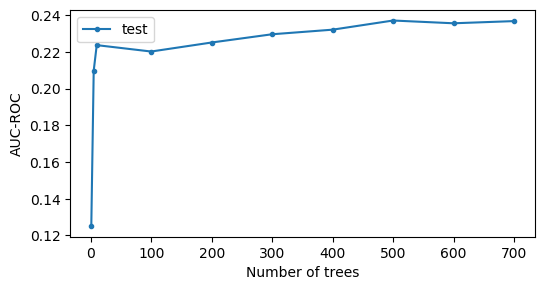

In [139]:
time_list = []

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_test = []
for n in n_trees:
    start_time = time.time()
    clf = CatBoostClassifier(n_estimators=n, cat_features=categorical)
    clf.fit(X_train, y_train)
    q_test = metrics.average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(6, 3))
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Learning rate set to 0.259609
0:	learn: 0.4776082	total: 166ms	remaining: 49.8s
1:	learn: 0.3700563	total: 308ms	remaining: 45.9s
2:	learn: 0.3197481	total: 406ms	remaining: 40.2s
3:	learn: 0.2932796	total: 551ms	remaining: 40.8s
4:	learn: 0.2806087	total: 643ms	remaining: 38s
5:	learn: 0.2734563	total: 743ms	remaining: 36.4s
6:	learn: 0.2694016	total: 859ms	remaining: 36s
7:	learn: 0.2668796	total: 1.01s	remaining: 37.1s
8:	learn: 0.2654984	total: 1.18s	remaining: 38.2s
9:	learn: 0.2639165	total: 1.29s	remaining: 37.3s
10:	learn: 0.2626895	total: 1.39s	remaining: 36.5s
11:	learn: 0.2621300	total: 1.48s	remaining: 35.5s
12:	learn: 0.2614664	total: 1.63s	remaining: 36s
13:	learn: 0.2608358	total: 1.73s	remaining: 35.3s
14:	learn: 0.2603689	total: 1.82s	remaining: 34.5s
15:	learn: 0.2595898	total: 1.91s	remaining: 33.9s
16:	learn: 0.2592391	total: 2s	remaining: 33.3s
17:	learn: 0.2586198	total: 2.1s	remaining: 33s
18:	learn: 0.2584055	total: 2.22s	remaining: 32.8s
19:	learn: 0.2580699	to

162:	learn: 0.2480272	total: 16.6s	remaining: 13.9s
163:	learn: 0.2480121	total: 16.7s	remaining: 13.8s
164:	learn: 0.2479933	total: 16.8s	remaining: 13.7s
165:	learn: 0.2479795	total: 16.9s	remaining: 13.6s
166:	learn: 0.2479655	total: 17s	remaining: 13.5s
167:	learn: 0.2479519	total: 17.1s	remaining: 13.4s
168:	learn: 0.2479356	total: 17.2s	remaining: 13.3s
169:	learn: 0.2479222	total: 17.3s	remaining: 13.2s
170:	learn: 0.2479053	total: 17.4s	remaining: 13.1s
171:	learn: 0.2478802	total: 17.5s	remaining: 13s
172:	learn: 0.2478716	total: 17.6s	remaining: 12.9s
173:	learn: 0.2478613	total: 17.7s	remaining: 12.8s
174:	learn: 0.2478559	total: 17.8s	remaining: 12.7s
175:	learn: 0.2478526	total: 17.9s	remaining: 12.6s
176:	learn: 0.2478410	total: 18s	remaining: 12.5s
177:	learn: 0.2478246	total: 18.1s	remaining: 12.4s
178:	learn: 0.2478184	total: 18.2s	remaining: 12.3s
179:	learn: 0.2478060	total: 18.3s	remaining: 12.2s
180:	learn: 0.2478016	total: 18.5s	remaining: 12.1s
181:	learn: 0.2477

21:	learn: 0.2514044	total: 7.62s	remaining: 1m 36s
22:	learn: 0.2511474	total: 7.96s	remaining: 1m 35s
23:	learn: 0.2509358	total: 8.25s	remaining: 1m 34s
24:	learn: 0.2506608	total: 8.57s	remaining: 1m 34s
25:	learn: 0.2504150	total: 8.89s	remaining: 1m 33s
26:	learn: 0.2502399	total: 9.21s	remaining: 1m 33s
27:	learn: 0.2501061	total: 9.54s	remaining: 1m 32s
28:	learn: 0.2499815	total: 9.83s	remaining: 1m 31s
29:	learn: 0.2498148	total: 10.1s	remaining: 1m 31s
30:	learn: 0.2494093	total: 10.5s	remaining: 1m 31s
31:	learn: 0.2493246	total: 10.8s	remaining: 1m 30s
32:	learn: 0.2491757	total: 11.1s	remaining: 1m 30s
33:	learn: 0.2489801	total: 11.5s	remaining: 1m 29s
34:	learn: 0.2488398	total: 11.8s	remaining: 1m 29s
35:	learn: 0.2487706	total: 12.1s	remaining: 1m 28s
36:	learn: 0.2486522	total: 12.4s	remaining: 1m 28s
37:	learn: 0.2485765	total: 12.7s	remaining: 1m 27s
38:	learn: 0.2485584	total: 13s	remaining: 1m 27s
39:	learn: 0.2484339	total: 13.5s	remaining: 1m 27s
40:	learn: 0.2

181:	learn: 0.2414058	total: 59.6s	remaining: 38.6s
182:	learn: 0.2413826	total: 59.9s	remaining: 38.3s
183:	learn: 0.2413614	total: 1m	remaining: 38s
184:	learn: 0.2413309	total: 1m	remaining: 37.6s
185:	learn: 0.2413175	total: 1m	remaining: 37.3s
186:	learn: 0.2412996	total: 1m 1s	remaining: 37s
187:	learn: 0.2412729	total: 1m 1s	remaining: 36.7s
188:	learn: 0.2412301	total: 1m 1s	remaining: 36.4s
189:	learn: 0.2411908	total: 1m 2s	remaining: 36s
190:	learn: 0.2411492	total: 1m 2s	remaining: 35.7s
191:	learn: 0.2410992	total: 1m 2s	remaining: 35.4s
192:	learn: 0.2410639	total: 1m 3s	remaining: 35s
193:	learn: 0.2410339	total: 1m 3s	remaining: 34.7s
194:	learn: 0.2410335	total: 1m 3s	remaining: 34.4s
195:	learn: 0.2410007	total: 1m 4s	remaining: 34s
196:	learn: 0.2409682	total: 1m 4s	remaining: 33.7s
197:	learn: 0.2409490	total: 1m 4s	remaining: 33.4s
198:	learn: 0.2409177	total: 1m 5s	remaining: 33.1s
199:	learn: 0.2408894	total: 1m 5s	remaining: 32.7s
200:	learn: 0.2408781	total: 1m

38:	learn: 0.2458415	total: 21.7s	remaining: 2m 25s
39:	learn: 0.2457162	total: 22.3s	remaining: 2m 25s
40:	learn: 0.2456340	total: 22.8s	remaining: 2m 24s
41:	learn: 0.2455322	total: 23.4s	remaining: 2m 23s
42:	learn: 0.2454254	total: 23.9s	remaining: 2m 22s
43:	learn: 0.2453837	total: 24.4s	remaining: 2m 21s
44:	learn: 0.2452995	total: 24.9s	remaining: 2m 20s
45:	learn: 0.2451605	total: 25.4s	remaining: 2m 20s
46:	learn: 0.2450228	total: 26s	remaining: 2m 19s
47:	learn: 0.2448956	total: 26.5s	remaining: 2m 19s
48:	learn: 0.2447150	total: 27.1s	remaining: 2m 18s
49:	learn: 0.2445714	total: 27.8s	remaining: 2m 18s
50:	learn: 0.2444004	total: 28.5s	remaining: 2m 18s
51:	learn: 0.2443799	total: 29.2s	remaining: 2m 19s
52:	learn: 0.2443201	total: 29.8s	remaining: 2m 18s
53:	learn: 0.2441771	total: 30.4s	remaining: 2m 18s
54:	learn: 0.2440949	total: 30.9s	remaining: 2m 17s
55:	learn: 0.2439407	total: 31.5s	remaining: 2m 17s
56:	learn: 0.2437385	total: 32s	remaining: 2m 16s
57:	learn: 0.243

194:	learn: 0.2331454	total: 2m 4s	remaining: 1m 7s
195:	learn: 0.2330570	total: 2m 4s	remaining: 1m 6s
196:	learn: 0.2329386	total: 2m 5s	remaining: 1m 5s
197:	learn: 0.2328693	total: 2m 5s	remaining: 1m 4s
198:	learn: 0.2327813	total: 2m 6s	remaining: 1m 4s
199:	learn: 0.2326582	total: 2m 6s	remaining: 1m 3s
200:	learn: 0.2325970	total: 2m 7s	remaining: 1m 2s
201:	learn: 0.2325400	total: 2m 7s	remaining: 1m 1s
202:	learn: 0.2324334	total: 2m 7s	remaining: 1m 1s
203:	learn: 0.2323628	total: 2m 8s	remaining: 1m
204:	learn: 0.2322688	total: 2m 8s	remaining: 59.7s
205:	learn: 0.2322586	total: 2m 9s	remaining: 59s
206:	learn: 0.2321662	total: 2m 9s	remaining: 58.4s
207:	learn: 0.2320747	total: 2m 10s	remaining: 57.7s
208:	learn: 0.2320490	total: 2m 11s	remaining: 57s
209:	learn: 0.2319729	total: 2m 11s	remaining: 56.4s
210:	learn: 0.2319112	total: 2m 12s	remaining: 55.7s
211:	learn: 0.2318788	total: 2m 12s	remaining: 55.1s
212:	learn: 0.2318531	total: 2m 13s	remaining: 54.4s
213:	learn: 0

51:	learn: 0.2392186	total: 35.3s	remaining: 2m 48s
52:	learn: 0.2388911	total: 36.1s	remaining: 2m 48s
53:	learn: 0.2388513	total: 36.8s	remaining: 2m 47s
54:	learn: 0.2386673	total: 37.7s	remaining: 2m 47s
55:	learn: 0.2385406	total: 38.4s	remaining: 2m 47s
56:	learn: 0.2383904	total: 39.1s	remaining: 2m 46s
57:	learn: 0.2382102	total: 39.8s	remaining: 2m 46s
58:	learn: 0.2379928	total: 40.4s	remaining: 2m 45s
59:	learn: 0.2377313	total: 41.2s	remaining: 2m 44s
60:	learn: 0.2374305	total: 41.9s	remaining: 2m 44s
61:	learn: 0.2373879	total: 42.5s	remaining: 2m 43s
62:	learn: 0.2371718	total: 43.2s	remaining: 2m 42s
63:	learn: 0.2370261	total: 43.9s	remaining: 2m 41s
64:	learn: 0.2366939	total: 44.7s	remaining: 2m 41s
65:	learn: 0.2364926	total: 45.4s	remaining: 2m 40s
66:	learn: 0.2362908	total: 46s	remaining: 2m 40s
67:	learn: 0.2361327	total: 46.7s	remaining: 2m 39s
68:	learn: 0.2360220	total: 47.3s	remaining: 2m 38s
69:	learn: 0.2358256	total: 48s	remaining: 2m 37s
70:	learn: 0.235

206:	learn: 0.2156750	total: 2m 19s	remaining: 1m 2s
207:	learn: 0.2154767	total: 2m 20s	remaining: 1m 2s
208:	learn: 0.2153027	total: 2m 21s	remaining: 1m 1s
209:	learn: 0.2150405	total: 2m 21s	remaining: 1m
210:	learn: 0.2148605	total: 2m 22s	remaining: 1m
211:	learn: 0.2147374	total: 2m 23s	remaining: 59.4s
212:	learn: 0.2145552	total: 2m 23s	remaining: 58.8s
213:	learn: 0.2143065	total: 2m 24s	remaining: 58.1s
214:	learn: 0.2142574	total: 2m 25s	remaining: 57.4s
215:	learn: 0.2142246	total: 2m 25s	remaining: 56.8s
216:	learn: 0.2140856	total: 2m 26s	remaining: 56.1s
217:	learn: 0.2140101	total: 2m 27s	remaining: 55.4s
218:	learn: 0.2138085	total: 2m 27s	remaining: 54.7s
219:	learn: 0.2136580	total: 2m 28s	remaining: 54.1s
220:	learn: 0.2134717	total: 2m 29s	remaining: 53.4s
221:	learn: 0.2134276	total: 2m 29s	remaining: 52.7s
222:	learn: 0.2131887	total: 2m 30s	remaining: 52s
223:	learn: 0.2129684	total: 2m 31s	remaining: 51.4s
224:	learn: 0.2129472	total: 2m 32s	remaining: 50.7s
2

63:	learn: 0.2211104	total: 1m 3s	remaining: 3m 55s
64:	learn: 0.2207619	total: 1m 4s	remaining: 3m 54s
65:	learn: 0.2205836	total: 1m 5s	remaining: 3m 53s
66:	learn: 0.2202279	total: 1m 6s	remaining: 3m 52s
67:	learn: 0.2200191	total: 1m 7s	remaining: 3m 51s
68:	learn: 0.2197755	total: 1m 8s	remaining: 3m 50s
69:	learn: 0.2195743	total: 1m 9s	remaining: 3m 49s
70:	learn: 0.2190262	total: 1m 10s	remaining: 3m 48s
71:	learn: 0.2184916	total: 1m 11s	remaining: 3m 47s
72:	learn: 0.2183513	total: 1m 13s	remaining: 3m 47s
73:	learn: 0.2179604	total: 1m 14s	remaining: 3m 46s
74:	learn: 0.2175303	total: 1m 15s	remaining: 3m 45s
75:	learn: 0.2171295	total: 1m 16s	remaining: 3m 44s
76:	learn: 0.2166868	total: 1m 17s	remaining: 3m 44s
77:	learn: 0.2164971	total: 1m 18s	remaining: 3m 43s
78:	learn: 0.2164244	total: 1m 19s	remaining: 3m 42s
79:	learn: 0.2162530	total: 1m 20s	remaining: 3m 41s
80:	learn: 0.2156271	total: 1m 21s	remaining: 3m 40s
81:	learn: 0.2151417	total: 1m 22s	remaining: 3m 39s


217:	learn: 0.1774104	total: 3m 43s	remaining: 1m 24s
218:	learn: 0.1770720	total: 3m 44s	remaining: 1m 23s
219:	learn: 0.1767635	total: 3m 45s	remaining: 1m 22s
220:	learn: 0.1764302	total: 3m 46s	remaining: 1m 20s
221:	learn: 0.1763118	total: 3m 47s	remaining: 1m 19s
222:	learn: 0.1761811	total: 3m 48s	remaining: 1m 18s
223:	learn: 0.1760579	total: 3m 49s	remaining: 1m 17s
224:	learn: 0.1758627	total: 3m 50s	remaining: 1m 16s
225:	learn: 0.1757461	total: 3m 51s	remaining: 1m 15s
226:	learn: 0.1756052	total: 3m 52s	remaining: 1m 14s
227:	learn: 0.1750034	total: 3m 54s	remaining: 1m 13s
228:	learn: 0.1747393	total: 3m 55s	remaining: 1m 12s
229:	learn: 0.1743897	total: 3m 56s	remaining: 1m 11s
230:	learn: 0.1739144	total: 3m 57s	remaining: 1m 10s
231:	learn: 0.1738787	total: 3m 58s	remaining: 1m 9s
232:	learn: 0.1737445	total: 3m 59s	remaining: 1m 8s
233:	learn: 0.1734870	total: 4m	remaining: 1m 7s
234:	learn: 0.1731425	total: 4m 1s	remaining: 1m 6s
235:	learn: 0.1725914	total: 4m 2s	re

74:	learn: 0.1859479	total: 2m 35s	remaining: 7m 46s
75:	learn: 0.1854566	total: 2m 37s	remaining: 7m 45s
76:	learn: 0.1842887	total: 2m 40s	remaining: 7m 43s
77:	learn: 0.1839232	total: 2m 42s	remaining: 7m 42s
78:	learn: 0.1825435	total: 2m 44s	remaining: 7m 40s
79:	learn: 0.1816989	total: 2m 47s	remaining: 7m 40s
80:	learn: 0.1812054	total: 2m 49s	remaining: 7m 38s
81:	learn: 0.1804877	total: 2m 51s	remaining: 7m 36s
82:	learn: 0.1798174	total: 2m 54s	remaining: 7m 35s
83:	learn: 0.1794592	total: 2m 56s	remaining: 7m 33s
84:	learn: 0.1788841	total: 2m 58s	remaining: 7m 31s
85:	learn: 0.1785964	total: 3m 1s	remaining: 7m 30s
86:	learn: 0.1776332	total: 3m 3s	remaining: 7m 29s
87:	learn: 0.1770272	total: 3m 6s	remaining: 7m 28s
88:	learn: 0.1761534	total: 3m 8s	remaining: 7m 26s
89:	learn: 0.1754597	total: 3m 10s	remaining: 7m 24s
90:	learn: 0.1747384	total: 3m 13s	remaining: 7m 23s
91:	learn: 0.1743875	total: 3m 15s	remaining: 7m 21s
92:	learn: 0.1734005	total: 3m 17s	remaining: 7m 2

228:	learn: 0.1091915	total: 8m 55s	remaining: 2m 46s
229:	learn: 0.1091562	total: 8m 58s	remaining: 2m 43s
230:	learn: 0.1087257	total: 9m	remaining: 2m 41s
231:	learn: 0.1082690	total: 9m 4s	remaining: 2m 39s
232:	learn: 0.1082258	total: 9m 6s	remaining: 2m 37s
233:	learn: 0.1074479	total: 9m 9s	remaining: 2m 34s
234:	learn: 0.1071065	total: 9m 11s	remaining: 2m 32s
235:	learn: 0.1067452	total: 9m 14s	remaining: 2m 30s
236:	learn: 0.1066626	total: 9m 16s	remaining: 2m 27s
237:	learn: 0.1065988	total: 9m 18s	remaining: 2m 25s
238:	learn: 0.1061309	total: 9m 21s	remaining: 2m 23s
239:	learn: 0.1061188	total: 9m 24s	remaining: 2m 21s
240:	learn: 0.1058944	total: 9m 26s	remaining: 2m 18s
241:	learn: 0.1058641	total: 9m 28s	remaining: 2m 16s
242:	learn: 0.1054849	total: 9m 31s	remaining: 2m 14s
243:	learn: 0.1053890	total: 9m 34s	remaining: 2m 11s
244:	learn: 0.1052167	total: 9m 36s	remaining: 2m 9s
245:	learn: 0.1048089	total: 9m 38s	remaining: 2m 7s
246:	learn: 0.1042067	total: 9m 41s	r

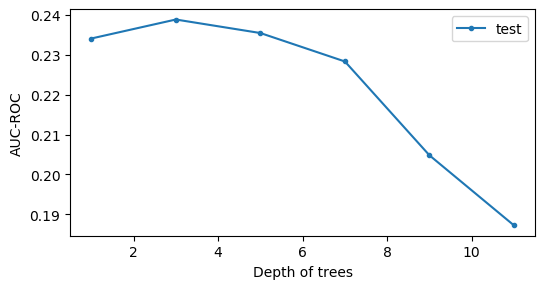

In [140]:
time_list = []

depth = list(range(1, 12, 2))
n_trees = 300
quals_test = []
for d in depth:
    start_time = time.time() 
    lgb = CatBoostClassifier(n_estimators=n_trees, max_depth=d, cat_features=categorical)
    lgb.fit(X_train, y_train)
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(6, 3))
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

0:	learn: 0.5948559	total: 476ms	remaining: 2m 22s
1:	learn: 0.5154547	total: 974ms	remaining: 2m 25s
2:	learn: 0.4612867	total: 1.31s	remaining: 2m 9s
3:	learn: 0.4181209	total: 1.72s	remaining: 2m 7s
4:	learn: 0.3861464	total: 2.16s	remaining: 2m 7s
5:	learn: 0.3599418	total: 2.49s	remaining: 2m 2s
6:	learn: 0.3380439	total: 2.86s	remaining: 1m 59s
7:	learn: 0.3237040	total: 3.21s	remaining: 1m 57s
8:	learn: 0.3108242	total: 3.73s	remaining: 2m
9:	learn: 0.3004528	total: 4.12s	remaining: 1m 59s
10:	learn: 0.2931960	total: 4.47s	remaining: 1m 57s
11:	learn: 0.2858986	total: 4.82s	remaining: 1m 55s
12:	learn: 0.2803698	total: 5.18s	remaining: 1m 54s
13:	learn: 0.2764866	total: 5.57s	remaining: 1m 53s
14:	learn: 0.2728597	total: 6s	remaining: 1m 54s
15:	learn: 0.2704123	total: 6.36s	remaining: 1m 52s
16:	learn: 0.2681672	total: 6.73s	remaining: 1m 51s
17:	learn: 0.2666295	total: 7.07s	remaining: 1m 50s
18:	learn: 0.2649564	total: 7.4s	remaining: 1m 49s
19:	learn: 0.2636591	total: 7.75s	

159:	learn: 0.2462796	total: 56.6s	remaining: 49.5s
160:	learn: 0.2462753	total: 56.8s	remaining: 49.1s
161:	learn: 0.2462527	total: 57.1s	remaining: 48.7s
162:	learn: 0.2462449	total: 57.4s	remaining: 48.2s
163:	learn: 0.2462361	total: 57.7s	remaining: 47.8s
164:	learn: 0.2462087	total: 58s	remaining: 47.4s
165:	learn: 0.2461948	total: 58.3s	remaining: 47.1s
166:	learn: 0.2461731	total: 58.6s	remaining: 46.7s
167:	learn: 0.2461525	total: 58.9s	remaining: 46.3s
168:	learn: 0.2461096	total: 59.2s	remaining: 45.9s
169:	learn: 0.2460719	total: 59.4s	remaining: 45.4s
170:	learn: 0.2460346	total: 59.7s	remaining: 45s
171:	learn: 0.2459963	total: 1m	remaining: 44.8s
172:	learn: 0.2459683	total: 1m	remaining: 44.5s
173:	learn: 0.2459426	total: 1m	remaining: 44.1s
174:	learn: 0.2459201	total: 1m 1s	remaining: 43.7s
175:	learn: 0.2458971	total: 1m 1s	remaining: 43.5s
176:	learn: 0.2458674	total: 1m 1s	remaining: 43.1s
177:	learn: 0.2458570	total: 1m 2s	remaining: 42.7s
178:	learn: 0.2458403	tot

16:	learn: 0.2548740	total: 6.04s	remaining: 1m 40s
17:	learn: 0.2542893	total: 6.41s	remaining: 1m 40s
18:	learn: 0.2539439	total: 6.79s	remaining: 1m 40s
19:	learn: 0.2536824	total: 7.12s	remaining: 1m 39s
20:	learn: 0.2532409	total: 7.53s	remaining: 1m 40s
21:	learn: 0.2529070	total: 7.87s	remaining: 1m 39s
22:	learn: 0.2527031	total: 8.34s	remaining: 1m 40s
23:	learn: 0.2524517	total: 8.72s	remaining: 1m 40s
24:	learn: 0.2521580	total: 9.17s	remaining: 1m 40s
25:	learn: 0.2518896	total: 9.51s	remaining: 1m 40s
26:	learn: 0.2515184	total: 9.84s	remaining: 1m 39s
27:	learn: 0.2512054	total: 10.1s	remaining: 1m 38s
28:	learn: 0.2509011	total: 10.5s	remaining: 1m 37s
29:	learn: 0.2507601	total: 10.8s	remaining: 1m 37s
30:	learn: 0.2505926	total: 11.1s	remaining: 1m 36s
31:	learn: 0.2504437	total: 11.5s	remaining: 1m 36s
32:	learn: 0.2501399	total: 11.8s	remaining: 1m 35s
33:	learn: 0.2500339	total: 12.1s	remaining: 1m 34s
34:	learn: 0.2498986	total: 12.4s	remaining: 1m 33s
35:	learn: 0

175:	learn: 0.2430788	total: 56.8s	remaining: 40s
176:	learn: 0.2430505	total: 57.1s	remaining: 39.7s
177:	learn: 0.2430475	total: 57.4s	remaining: 39.4s
178:	learn: 0.2430457	total: 57.7s	remaining: 39s
179:	learn: 0.2430191	total: 58s	remaining: 38.6s
180:	learn: 0.2430055	total: 58.3s	remaining: 38.3s
181:	learn: 0.2429765	total: 58.5s	remaining: 37.9s
182:	learn: 0.2429396	total: 58.7s	remaining: 37.5s
183:	learn: 0.2429382	total: 59s	remaining: 37.2s
184:	learn: 0.2429004	total: 59.3s	remaining: 36.8s
185:	learn: 0.2428631	total: 59.5s	remaining: 36.5s
186:	learn: 0.2428448	total: 59.9s	remaining: 36.2s
187:	learn: 0.2428216	total: 1m	remaining: 35.9s
188:	learn: 0.2427872	total: 1m	remaining: 35.5s
189:	learn: 0.2427751	total: 1m	remaining: 35.3s
190:	learn: 0.2427652	total: 1m 1s	remaining: 34.9s
191:	learn: 0.2427321	total: 1m 1s	remaining: 34.6s
192:	learn: 0.2426920	total: 1m 1s	remaining: 34.3s
193:	learn: 0.2426655	total: 1m 2s	remaining: 33.9s
194:	learn: 0.2426606	total: 

33:	learn: 0.2485095	total: 10.1s	remaining: 1m 18s
34:	learn: 0.2483922	total: 10.4s	remaining: 1m 18s
35:	learn: 0.2482489	total: 10.7s	remaining: 1m 18s
36:	learn: 0.2481548	total: 11s	remaining: 1m 18s
37:	learn: 0.2480710	total: 11.3s	remaining: 1m 17s
38:	learn: 0.2479914	total: 11.6s	remaining: 1m 17s
39:	learn: 0.2478916	total: 11.8s	remaining: 1m 16s
40:	learn: 0.2477926	total: 12.1s	remaining: 1m 16s
41:	learn: 0.2476926	total: 12.3s	remaining: 1m 15s
42:	learn: 0.2475343	total: 12.6s	remaining: 1m 15s
43:	learn: 0.2473577	total: 12.8s	remaining: 1m 14s
44:	learn: 0.2472967	total: 13.1s	remaining: 1m 14s
45:	learn: 0.2472429	total: 13.4s	remaining: 1m 13s
46:	learn: 0.2471688	total: 13.6s	remaining: 1m 13s
47:	learn: 0.2470821	total: 13.9s	remaining: 1m 12s
48:	learn: 0.2468847	total: 14.2s	remaining: 1m 12s
49:	learn: 0.2467662	total: 14.6s	remaining: 1m 12s
50:	learn: 0.2466478	total: 15s	remaining: 1m 13s
51:	learn: 0.2465838	total: 15.4s	remaining: 1m 13s
52:	learn: 0.246

193:	learn: 0.2410202	total: 59.5s	remaining: 32.5s
194:	learn: 0.2409938	total: 59.9s	remaining: 32.2s
195:	learn: 0.2409715	total: 1m	remaining: 31.9s
196:	learn: 0.2409205	total: 1m	remaining: 31.6s
197:	learn: 0.2409075	total: 1m	remaining: 31.4s
198:	learn: 0.2408696	total: 1m 1s	remaining: 31.1s
199:	learn: 0.2408342	total: 1m 1s	remaining: 30.7s
200:	learn: 0.2408070	total: 1m 1s	remaining: 30.4s
201:	learn: 0.2407690	total: 1m 2s	remaining: 30.1s
202:	learn: 0.2407410	total: 1m 2s	remaining: 29.8s
203:	learn: 0.2407309	total: 1m 2s	remaining: 29.5s
204:	learn: 0.2407245	total: 1m 2s	remaining: 29.1s
205:	learn: 0.2407005	total: 1m 3s	remaining: 28.8s
206:	learn: 0.2406681	total: 1m 3s	remaining: 28.5s
207:	learn: 0.2406142	total: 1m 3s	remaining: 28.3s
208:	learn: 0.2405531	total: 1m 4s	remaining: 28s
209:	learn: 0.2405430	total: 1m 4s	remaining: 27.7s
210:	learn: 0.2405180	total: 1m 4s	remaining: 27.4s
211:	learn: 0.2404603	total: 1m 5s	remaining: 27s
212:	learn: 0.2404108	tot

51:	learn: 0.2456497	total: 17.8s	remaining: 1m 25s
52:	learn: 0.2455671	total: 18.1s	remaining: 1m 24s
53:	learn: 0.2454583	total: 18.4s	remaining: 1m 23s
54:	learn: 0.2453737	total: 18.7s	remaining: 1m 23s
55:	learn: 0.2453078	total: 19s	remaining: 1m 22s
56:	learn: 0.2453012	total: 19.3s	remaining: 1m 22s
57:	learn: 0.2452951	total: 19.5s	remaining: 1m 21s
58:	learn: 0.2452531	total: 19.8s	remaining: 1m 20s
59:	learn: 0.2452053	total: 20.1s	remaining: 1m 20s
60:	learn: 0.2450974	total: 20.3s	remaining: 1m 19s
61:	learn: 0.2450650	total: 20.7s	remaining: 1m 19s
62:	learn: 0.2450123	total: 21s	remaining: 1m 18s
63:	learn: 0.2449447	total: 21.2s	remaining: 1m 18s
64:	learn: 0.2448934	total: 21.5s	remaining: 1m 17s
65:	learn: 0.2448672	total: 21.8s	remaining: 1m 17s
66:	learn: 0.2448444	total: 22.1s	remaining: 1m 16s
67:	learn: 0.2447452	total: 22.4s	remaining: 1m 16s
68:	learn: 0.2447029	total: 22.7s	remaining: 1m 16s
69:	learn: 0.2446191	total: 23.1s	remaining: 1m 15s
70:	learn: 0.244

211:	learn: 0.2383414	total: 1m 8s	remaining: 28.3s
212:	learn: 0.2383091	total: 1m 8s	remaining: 27.9s
213:	learn: 0.2382988	total: 1m 8s	remaining: 27.6s
214:	learn: 0.2382680	total: 1m 8s	remaining: 27.3s
215:	learn: 0.2382559	total: 1m 9s	remaining: 26.9s
216:	learn: 0.2382021	total: 1m 9s	remaining: 26.6s
217:	learn: 0.2381647	total: 1m 9s	remaining: 26.2s
218:	learn: 0.2381001	total: 1m 10s	remaining: 25.9s
219:	learn: 0.2380790	total: 1m 10s	remaining: 25.5s
220:	learn: 0.2380519	total: 1m 10s	remaining: 25.2s
221:	learn: 0.2380390	total: 1m 10s	remaining: 24.9s
222:	learn: 0.2380334	total: 1m 11s	remaining: 24.5s
223:	learn: 0.2379875	total: 1m 11s	remaining: 24.2s
224:	learn: 0.2379404	total: 1m 11s	remaining: 23.9s
225:	learn: 0.2379228	total: 1m 11s	remaining: 23.5s
226:	learn: 0.2378577	total: 1m 12s	remaining: 23.2s
227:	learn: 0.2378526	total: 1m 12s	remaining: 22.8s
228:	learn: 0.2377984	total: 1m 12s	remaining: 22.5s
229:	learn: 0.2377636	total: 1m 12s	remaining: 22.2s


69:	learn: 0.2436452	total: 19.5s	remaining: 1m 4s
70:	learn: 0.2435762	total: 19.8s	remaining: 1m 3s
71:	learn: 0.2434744	total: 20s	remaining: 1m 3s
72:	learn: 0.2433945	total: 20.3s	remaining: 1m 3s
73:	learn: 0.2433173	total: 20.5s	remaining: 1m 2s
74:	learn: 0.2432717	total: 20.8s	remaining: 1m 2s
75:	learn: 0.2431768	total: 21.1s	remaining: 1m 2s
76:	learn: 0.2431534	total: 21.4s	remaining: 1m 2s
77:	learn: 0.2431400	total: 21.7s	remaining: 1m 1s
78:	learn: 0.2430638	total: 22s	remaining: 1m 1s
79:	learn: 0.2429135	total: 22.2s	remaining: 1m 1s
80:	learn: 0.2428566	total: 22.5s	remaining: 1m
81:	learn: 0.2427764	total: 22.8s	remaining: 1m
82:	learn: 0.2427034	total: 23.1s	remaining: 1m
83:	learn: 0.2426676	total: 23.4s	remaining: 1m
84:	learn: 0.2426222	total: 23.6s	remaining: 59.8s
85:	learn: 0.2425758	total: 23.9s	remaining: 59.6s
86:	learn: 0.2425756	total: 24.2s	remaining: 59.3s
87:	learn: 0.2425313	total: 24.5s	remaining: 58.9s
88:	learn: 0.2424636	total: 24.7s	remaining: 58

229:	learn: 0.2358201	total: 1m 3s	remaining: 19.2s
230:	learn: 0.2357903	total: 1m 3s	remaining: 18.9s
231:	learn: 0.2357172	total: 1m 3s	remaining: 18.6s
232:	learn: 0.2356753	total: 1m 3s	remaining: 18.4s
233:	learn: 0.2356358	total: 1m 4s	remaining: 18.1s
234:	learn: 0.2356194	total: 1m 4s	remaining: 17.8s
235:	learn: 0.2356002	total: 1m 4s	remaining: 17.5s
236:	learn: 0.2355546	total: 1m 4s	remaining: 17.3s
237:	learn: 0.2355333	total: 1m 5s	remaining: 17s
238:	learn: 0.2354853	total: 1m 5s	remaining: 16.7s
239:	learn: 0.2354464	total: 1m 5s	remaining: 16.5s
240:	learn: 0.2354011	total: 1m 6s	remaining: 16.2s
241:	learn: 0.2353254	total: 1m 6s	remaining: 15.9s
242:	learn: 0.2352947	total: 1m 6s	remaining: 15.6s
243:	learn: 0.2352499	total: 1m 6s	remaining: 15.4s
244:	learn: 0.2351913	total: 1m 7s	remaining: 15.1s
245:	learn: 0.2351645	total: 1m 7s	remaining: 14.8s
246:	learn: 0.2351196	total: 1m 7s	remaining: 14.6s
247:	learn: 0.2351018	total: 1m 8s	remaining: 14.3s
248:	learn: 0.

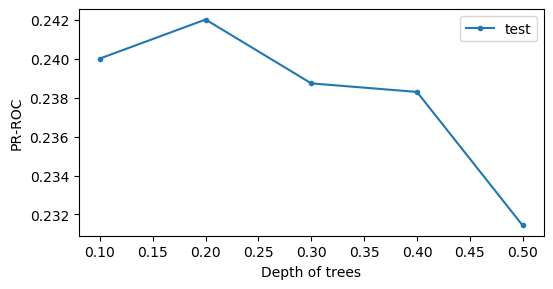

In [143]:
time_list = []

depth = 3
eta = np.arange(1, 6) / 10
quals_test = []
for e in eta:
    start_time = time.time()
    lgb = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, eta=e, cat_features=categorical)
    lgb.fit(X_train, y_train)
    q_test = metrics.average_precision_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_test.append(q_test)
    time_list.append(time.time() - start_time)

print("Mean time:", np.mean(time_list))
plt.figure(figsize=(6, 3))
plt.plot(eta, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('PR-ROC')
plt.legend()

plt.show()

In [144]:
eta = eta[np.argmax(quals_test)]

print("Number of trees:", n_trees)
print("Max depth:", depth)
print("Learning rate:", eta)

Number of trees: 300
Max depth: 3
Learning rate: 0.2


Посмотрим на итоговое качество:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(removed_data, Y, test_size=0.30, random_state=1, stratify=Y)

In [16]:
encoder = ce.CountEncoder(cols=categorical)

count_X_train = encoder.fit_transform(X_train, y_train)
count_X_test = encoder.transform(X_test, y_train)

In [17]:
model = LGBMClassifier(max_depth=4, n_estimators=100)
model.fit(count_X_train, y_train)
l_pred = model.predict_proba(count_X_test)

cat = CatBoostClassifier(max_depth=3, n_estimators=300, eta=0.2, cat_features=categorical)
cat.fit(X_train, y_train)
cat_pred = cat.predict_proba(X_test)

0:	learn: 0.5178149	total: 503ms	remaining: 2m 30s
1:	learn: 0.4079550	total: 767ms	remaining: 1m 54s
2:	learn: 0.3535628	total: 1.08s	remaining: 1m 46s
3:	learn: 0.3170878	total: 1.37s	remaining: 1m 41s
4:	learn: 0.2970994	total: 1.64s	remaining: 1m 36s
5:	learn: 0.2844458	total: 1.95s	remaining: 1m 35s
6:	learn: 0.2752370	total: 2.23s	remaining: 1m 33s
7:	learn: 0.2699269	total: 2.5s	remaining: 1m 31s
8:	learn: 0.2661915	total: 2.78s	remaining: 1m 30s
9:	learn: 0.2634118	total: 3.07s	remaining: 1m 29s
10:	learn: 0.2613267	total: 3.38s	remaining: 1m 28s
11:	learn: 0.2598118	total: 3.64s	remaining: 1m 27s
12:	learn: 0.2587810	total: 3.91s	remaining: 1m 26s
13:	learn: 0.2578293	total: 4.15s	remaining: 1m 24s
14:	learn: 0.2571155	total: 4.41s	remaining: 1m 23s
15:	learn: 0.2562307	total: 4.7s	remaining: 1m 23s
16:	learn: 0.2556632	total: 5.01s	remaining: 1m 23s
17:	learn: 0.2548870	total: 5.31s	remaining: 1m 23s
18:	learn: 0.2545051	total: 5.55s	remaining: 1m 22s
19:	learn: 0.2539890	tot

160:	learn: 0.2443486	total: 47.1s	remaining: 40.7s
161:	learn: 0.2443184	total: 47.4s	remaining: 40.4s
162:	learn: 0.2442437	total: 47.7s	remaining: 40.1s
163:	learn: 0.2442015	total: 48s	remaining: 39.8s
164:	learn: 0.2441517	total: 48.3s	remaining: 39.5s
165:	learn: 0.2441243	total: 48.5s	remaining: 39.2s
166:	learn: 0.2441065	total: 48.8s	remaining: 38.9s
167:	learn: 0.2440764	total: 49.1s	remaining: 38.6s
168:	learn: 0.2440693	total: 49.4s	remaining: 38.3s
169:	learn: 0.2440550	total: 49.7s	remaining: 38s
170:	learn: 0.2440362	total: 50.1s	remaining: 37.8s
171:	learn: 0.2440183	total: 50.4s	remaining: 37.5s
172:	learn: 0.2440087	total: 50.7s	remaining: 37.2s
173:	learn: 0.2439443	total: 51s	remaining: 36.9s
174:	learn: 0.2439100	total: 51.2s	remaining: 36.6s
175:	learn: 0.2438950	total: 51.5s	remaining: 36.3s
176:	learn: 0.2438905	total: 51.8s	remaining: 36s
177:	learn: 0.2438892	total: 52.1s	remaining: 35.7s
178:	learn: 0.2438598	total: 52.4s	remaining: 35.4s
179:	learn: 0.243849

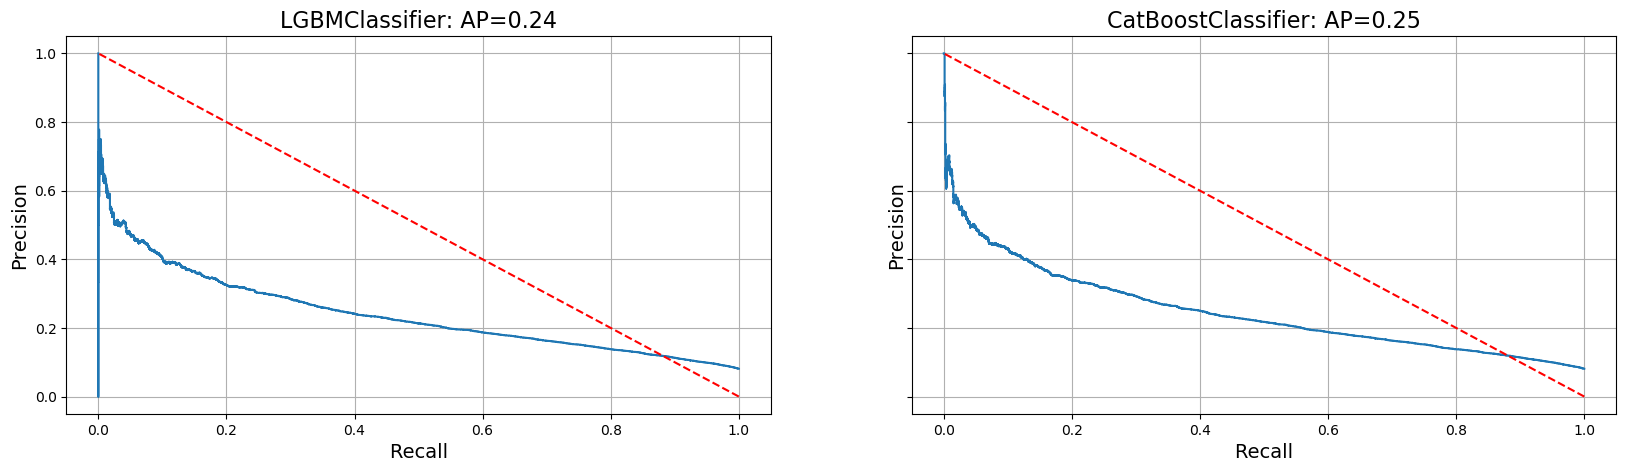

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
l_average_precision = metrics.average_precision_score(y_test, l_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, l_pred[:, 1])
ax1.step(recall, precision, where='post')
ax1.set_xlabel('Recall', fontsize=14)
ax1.set_ylabel('Precision', fontsize=14)
ax1.plot([1, 0], [0, 1],'r--')
ax1.set_title('LGBMClassifier: AP={0:0.2f}'.format(l_average_precision), fontsize=16)
ax1.grid()

cat_average_precision = metrics.average_precision_score(y_test, cat_pred[:, 1])
precision, recall, threshold = metrics.precision_recall_curve(y_test, cat_pred[:, 1])
ax2.step(recall, precision, where='post')
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.plot([1, 0], [0, 1],'r--')
ax2.set_title('CatBoostClassifier: AP={0:0.2f}'.format(cat_average_precision), fontsize=16)
ax2.grid()

In [19]:
print('LGBMClassifier: AP={0:0.6f}'.format(l_average_precision))
print('CatBoostClassifier: AP={0:0.6f}'.format(cat_average_precision))

LGBMClassifier: AP=0.240609
CatBoostClassifier: AP=0.247025


**Бонус (0.2 балла)**

Вставьте лучший мем 2020

![](https://sun9-64.userapi.com/c841230/v841230917/34efa/Wd22hcNCTJc.jpg)

![](meme.jpg)